In [1]:
# Dependencies
import matplotlib.pyplot as plt
import requests
import pandas as pd
from scipy.stats import linregress
from config import tmdb_api_key
from config import omdb_api_key
import json
import numpy as np
import cpi
import time

In [2]:
# Check that the CSV was read properly
movie_import = pd.read_csv("movies_metadata.csv", low_memory=False)
print(movie_import.shape)
movie_import.head()

(45466, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
movie_import.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [4]:
# Check the dataset's budget and revenue values to see how many entries don't have said data
print("Budget value counts:")
print(movie_import["budget"].value_counts())
print("---------------------------------------")
print("Revenue value counts:")
print(movie_import["revenue"].value_counts())

Budget value counts:
budget
0           36573
5000000       286
10000000      259
20000000      243
2000000       242
            ...  
923             1
72500000        1
2160000         1
4439832         1
1254040         1
Name: count, Length: 1226, dtype: int64
---------------------------------------
Revenue value counts:
revenue
0.0           38052
12000000.0       20
11000000.0       19
10000000.0       19
2000000.0        18
              ...  
36565280.0        1
439564.0          1
35610100.0        1
10217873.0        1
1413000.0         1
Name: count, Length: 6863, dtype: int64


In [5]:
# Drop duplicate movies (movie entries with the same title and release date) from the imported data
movie_import.drop_duplicates(subset=["release_date", "title"], keep='first', inplace=True)

In [6]:
# View if a movie had 0 budget or not (true/false)
# First, convert the budget column from a string to numeric and write NaN values to non-numeric cells
movie_import["budget"] = pd.to_numeric(movie_import['budget'], errors='coerce', downcast='integer')
no_budget = movie_import["budget"]==0
no_budget

0        False
1        False
2         True
3        False
4         True
         ...  
45461     True
45462     True
45463     True
45464     True
45465     True
Name: budget, Length: 45434, dtype: bool

In [7]:
# Create a DataFrame from the last cell's result
no_budget_df = movie_import[no_budget]
# Remove the rows with zero budget movies
movie_import=movie_import[~no_budget]
movie_import

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
5,False,NaN,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
6,False,NaN,58000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,...,1995-12-15,0.0,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45402,False,NaN,2000000.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,293654,tt3761706,ru,Корпоратив,"Igor, a furniture store manager, tries to figu...",...,2014-09-18,0.0,89.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Corporate Event,False,3.5,4.0
45408,False,NaN,2000000.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,100152,tt0417949,ru,Марс,"Somewhere deep, deep in Russia there is a town...",...,2004-11-11,0.0,100.0,[],Released,NaN,Mars,False,5.0,2.0
45409,False,NaN,800000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,62757,tt0933361,en,Dikari,"The sea, August, interesting and simple people...",...,2006-11-23,1328612.0,100.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Savages,False,5.8,6.0
45412,False,NaN,2000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,63281,tt1718881,en,Про любоff,"У девушки Даши, приехавшей с подругой «покорят...",...,2010-09-30,1268793.0,107.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Pro Lyuboff,False,4.0,3.0


In [8]:
# View if a movie had 0 budget or not (true/false)
# First, convert the budget column from a string to numeric and write NaN values to non-numeric cells
movie_import["revenue"] = pd.to_numeric(movie_import["revenue"], errors="coerce", downcast="float")
no_revenue = movie_import["revenue"]==0
no_revenue

0        False
1        False
3        False
5        False
6         True
         ...  
45402     True
45408     True
45409    False
45412    False
45422    False
Name: revenue, Length: 8883, dtype: bool

In [9]:
# Create a DataFrame from the last block's result
no_revenue_df = movie_import[no_revenue]
# Remove the rows with zero budget movies
movie_import=movie_import[~no_revenue]
print(movie_import.shape)
movie_import

(5378, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
5,False,NaN,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
8,False,NaN,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45250,False,NaN,12000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,24049,tt0479751,ta,சிவாஜி,Corrupt police and politicians target a comput...,...,2007-06-14,19000000.0,185.0,"[{'iso_639_1': 'ta', 'name': 'தமிழ்'}, {'iso_6...",Released,NaN,Sivaji: The Boss,False,6.9,25.0
45399,False,NaN,750000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",NaN,280422,tt3805180,ru,Все и сразу,NaN,...,2014-06-05,3.0,0.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,All at Once,False,6.0,4.0
45409,False,NaN,800000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,62757,tt0933361,en,Dikari,"The sea, August, interesting and simple people...",...,2006-11-23,1328612.0,100.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Savages,False,5.8,6.0
45412,False,NaN,2000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,63281,tt1718881,en,Про любоff,"У девушки Даши, приехавшей с подругой «покорят...",...,2010-09-30,1268793.0,107.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Pro Lyuboff,False,4.0,3.0


In [10]:
# Check if there are any 0 values remaining for either budget or revenue
print(f"Budget check: ")
print(movie_import["budget"].min())
print(f"Revenue check: ")
print(movie_import["revenue"].min())

Budget check: 
1.0
Revenue check: 
1.0


In [11]:
# Further fitler down the original movie dataset by removing movies with budgets and revenues less than $1000
movie_prep1 = movie_import[movie_import["budget"]>=1000]
movie_prep1 = movie_import[movie_import["revenue"]>=1000]
movie_prep1

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
5,False,NaN,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
8,False,NaN,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45167,False,NaN,11000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,395834,tt5362988,en,Wind River,An FBI agent teams with the town's veteran gam...,...,2017-08-03,184770205.0,111.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Nothing is harder to track than the truth.,Wind River,False,7.4,181.0
45250,False,NaN,12000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,24049,tt0479751,ta,சிவாஜி,Corrupt police and politicians target a comput...,...,2007-06-14,19000000.0,185.0,"[{'iso_639_1': 'ta', 'name': 'தமிழ்'}, {'iso_6...",Released,NaN,Sivaji: The Boss,False,6.9,25.0
45409,False,NaN,800000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,62757,tt0933361,en,Dikari,"The sea, August, interesting and simple people...",...,2006-11-23,1328612.0,100.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Savages,False,5.8,6.0
45412,False,NaN,2000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,63281,tt1718881,en,Про любоff,"У девушки Даши, приехавшей с подругой «покорят...",...,2010-09-30,1268793.0,107.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Pro Lyuboff,False,4.0,3.0


In [12]:
# Make a new DataFrame and import the title column from the metadata and make a blank id column to be populate
movie_prep2 = pd.DataFrame(movie_prep1["original_title"])
movie_prep2.rename(columns={"original_title": "Title"}, inplace=True)
movie_prep2['id'] = ''
movie_prep2

,Title,id
0,Toy Story,
1,Jumanji,
3,Waiting to Exhale,
5,Heat,
8,Sudden Death,
...,...,...
45167,Wind River,
45250,சிவாஜி,
45409,Dikari,
45412,Про любоff,


In [13]:
movie_list = movie_prep2.sample(1000)
movie_list = movie_list.reset_index(drop=True)
movie_list

,Title,id
0,The Big Hit,
1,The Fault in Our Stars,
2,Drop Dead Gorgeous,
3,Warlords of the 21st Century,
4,Treehouse,
...,...,...
995,The Hunger Games: Mockingjay - Part 1,
996,Morning Glory,
997,Death Wish 3,
998,The Last Exorcism,


In [14]:
# Test a TMDB API call based on an index of the movie list and printing the json response
movie=movie_list['Title'][100]
base_url="https://api.themoviedb.org/3/search/movie?"
build_url = f'https://api.themoviedb.org/3/search/movie?query={movie}&api_key={tmdb_api_key}'
response=requests.get(build_url).json()
#print(response.url)
print(json.dumps(response, indent=4, sort_keys=True))

{
    "page": 1,
    "results": [
        {
            "adult": false,
            "backdrop_path": "/8VPwE9Owon0lOUi1FdTfakEPVZM.jpg",
            "genre_ids": [
                18,
                35
            ],
            "id": 44009,
            "original_language": "en",
            "original_title": "Another Year",
            "overview": "During a year, a very content couple approaching retirement are visited by friends and family less happy with their lives.",
            "popularity": 10.995,
            "poster_path": "/zrkQcAatfBox5x9KZjaYGnKoqu6.jpg",
            "release_date": "2010-11-05",
            "title": "Another Year",
            "video": false,
            "vote_average": 6.984,
            "vote_count": 349
        },
        {
            "adult": false,
            "backdrop_path": null,
            "genre_ids": [
                99
            ],
            "id": 412359,
            "original_language": "zh",
            "original_title": "\u53c8\u4e00

In [15]:
# Test an OMDB API call based on an index of the movie list and printing the json response
url = "http://www.omdbapi.com/?t="
api_key_url = "&apikey=" + omdb_api_key
movie_name=movie_list["Title"][250]
response = requests.get(url + movie_name + api_key_url).json()
print(json.dumps(response, indent=4, sort_keys=True))

{
    "Actors": "Kristen Stewart, Lars Eidinger, Sigrid Bouaziz",
    "Awards": "9 wins & 24 nominations",
    "BoxOffice": "$1,305,195",
    "Country": "France, Germany, Czech Republic, Belgium",
    "DVD": "27 Jun 2017",
    "Director": "Olivier Assayas",
    "Genre": "Mystery, Thriller",
    "Language": "English, French, Swedish, German",
    "Metascore": "77",
    "Plot": "A personal shopper in Paris refuses to leave the city until she makes contact with her twin brother who previously died there. Her life becomes more complicated when a mysterious person contacts her via text message.",
    "Poster": "https://m.media-amazon.com/images/M/MV5BN2JhYTViMGUtMTU0Ni00MzU5LWE0ZmYtNDk2YTdmOTI5MTFjXkEyXkFqcGdeQXVyNTIyODMzMzA@._V1_SX300.jpg",
    "Production": "N/A",
    "Rated": "R",
    "Ratings": [
        {
            "Source": "Internet Movie Database",
            "Value": "6.1/10"
        },
        {
            "Source": "Rotten Tomatoes",
            "Value": "81%"
        },
    

In [16]:
# Loop through the CSV's Title column to call said movie from the TMDB API
# Create an empty list to store unfound movies in the TMDB database into
unfound_movies = []
for index, row in movie_list.iterrows():
    movie=movie_list['Title'][index]
    base_url="https://api.themoviedb.org/3/search/movie?"
    build_url = f'{base_url}query={movie}&api_key={tmdb_api_key}'
    response=requests.get(build_url).json()
    #print(response.url)

    try:
        movie_list.loc[index, "id"] = response['results'][0]['id']
    except (KeyError, IndexError):
        # If no movie name is found, set the movie id as NaN .
        movie_list.loc[index, "id"] = np.nan
        unfound_movies.append(movie_list.loc[index, "Title"])

# View the movies not found in the database
unfound_movies

['#Pellichoopulu', 'Gangs of वासेपुर']

In [17]:
# Cleaning: drop any NaN rows
movie_list.dropna(how='any',inplace=True)
# Reset the index to not run into any index errors while looping later in the cleaning
movie_list.reset_index(drop=True)
#Re-check size of Data Frame
movie_list.shape

(998, 2)

In [18]:
#Add new columns to the DataFrame to be populated with the next TMDB API calls
movie_list[['imdb_id',
            'budget',
            'genres',
            'revenue',
            'runtime',
            'popularity',
            'release_date',
            'production_countries'
            ,'tmdb_rating']] =''
movie_list

,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating
0,The Big Hit,9448,,,,,,,,,
1,The Fault in Our Stars,222935,,,,,,,,,
2,Drop Dead Gorgeous,10490,,,,,,,,,
3,Warlords of the 21st Century,27873,,,,,,,,,
4,Treehouse,580944,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...
995,The Hunger Games: Mockingjay - Part 1,131631,,,,,,,,,
996,Morning Glory,38357,,,,,,,,,
997,Death Wish 3,24873,,,,,,,,,
998,The Last Exorcism,38358,,,,,,,,,


In [19]:
# Loop through each movie's title for the TMDB API call and store the data we want to analyze into our DataFrame

for index, row in movie_list.iterrows():
# Create empty lists to store multiple-value columns' data into 
    genres = []
    production_countries = []
    try:
        movie_id=movie_list['id'][index]
        base_url_ById = "https://api.themoviedb.org/3/movie/"
        build_url_ById=f"{base_url_ById}{movie_id}?api_key={tmdb_api_key}"
        url_byid_response=requests.get(build_url_ById).json()
        movie_list.loc[index, "imdb_id"] = url_byid_response['imdb_id']
        movie_list.loc[index, "release_date"] = url_byid_response['release_date']
        movie_list.loc[index, "revenue"] = url_byid_response['revenue']
        movie_list.loc[index, "runtime"]= url_byid_response['runtime']
        movie_list.loc[index, "Title"]= url_byid_response['title']

        
        
        #extracting genre names from list
        for i in range(0,len(url_byid_response['genres'])):
            current_genre = url_byid_response['genres'][i]['name']
            genres.append(current_genre)
            

        #extracting production_countries names from list
        for i in range(0,len(url_byid_response['production_countries'])):
            current_prod_country = url_byid_response['production_countries'][i]['name']
            production_countries.append(current_prod_country)

        movie_list.loc[index, "popularity"] = url_byid_response['popularity']
        movie_list.loc[index, "budget"] = url_byid_response['budget']
        movie_list.loc[index, "tmdb_rating"] = url_byid_response['vote_average']
        movie_list.loc[index, "genres"] = ", ".join(genres)
        movie_list.loc[index, "production_countries"] = ", ".join(production_countries)
    except (KeyError, IndexError):
        # If no movie name is found, set the movie id as NaN .
        movie_list.loc[index, "imdb_id"] = np.nan
        movie_list.loc[index, "release_date"] = np.nan
        movie_list.loc[index, "revenue"] = np.nan
        movie_list.loc[index, "runtime"]= np.nan
        movie_list.loc[index, "popularity"] = np.nan
        movie_list.loc[index, "budget"] = np.nan
        movie_list.loc[index, "tmdb_rating"] = np.nan
        movie_list.loc[index, "production_countries"] = np.nan
        movie_list.loc[index, "genres"] = np.nan

        

In [20]:
# Make calls to the OMDB API to populate new rows with imdb ratings and their vote counts

for index, row in movie_list.iterrows():
    try:
        imdb_id=movie_list["imdb_id"][index]
        base_url_ById = "http://www.omdbapi.com/?i="
        build_url_ById=f"{base_url_ById}{imdb_id}&apikey={omdb_api_key}"
        url_byid_response=requests.get(build_url_ById).json()
        rating_url = url_byid_response['imdbRating']
        movie_list.loc[index, "imdb_rating"] = rating_url
        votes_url = url_byid_response['imdbVotes']
        movie_list.loc[index, "imdb_votes"] = votes_url
    except:
        movie_list.loc[index, "imdb_rating"] = np.nan
        movie_list.loc[index, "imdb_votes"] = np.nan
movie_list

,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating,imdb_rating,imdb_votes
0,The Big Hit,9448,tt0120609,13000000,"Action, Adventure, Comedy, Thriller",27007143,91,16.438,1998-04-24,United States of America,5.849,6.0,"31,038"
1,The Fault in Our Stars,222935,tt2582846,14000000,"Romance, Drama",307166834,126,30.6,2014-05-16,United States of America,7.6,7.7,"393,052"
2,Drop Dead Gorgeous,10490,tt0157503,10000000,Comedy,10571408,98,8.366,1999-07-23,United States of America,6.4,6.7,"39,709"
3,Warlords of the 21st Century,27873,tt0084887,1000000,"Science Fiction, Action, Adventure",3000000,91,4.694,1982-01-01,New Zealand,4.64,5.0,"1,476"
4,Treehouse,580944,tt9075656,0,"Horror, TV Movie",0,84,11.328,2019-03-01,United States of America,5.478,4.9,2405
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,The Hunger Games: Mockingjay - Part 1,131631,tt1951265,125000000,"Science Fiction, Adventure, Thriller",755356711,123,81.025,2014-11-19,"Canada, United States of America",6.797,6.6,"480,510"
996,Morning Glory,38357,tt1126618,40000000,"Drama, Comedy, Romance",60040976,107,12.597,2010-11-10,United States of America,6.34,6.5,"81,275"
997,Death Wish 3,24873,tt0089003,9000000,"Action, Crime, Drama",16116878,92,22.496,1985-11-01,United States of America,6.228,5.8,"16,691"
998,The Last Exorcism,38358,tt1320244,1800000,"Horror, Thriller, Mystery",69432527,87,41.824,2010-08-27,"United States of America, France",5.649,5.7,"51,339"


In [21]:
movie_list.dropna(how='any', inplace=True)
print(movie_list.shape)
movie_list = movie_list.reset_index(drop=True)

(995, 13)


In [22]:
import math
# Create a new "Year" column from the "release date" by making a new df converting to datetime
movie_list["release_date"] = pd.to_datetime(movie_list["release_date"])
movie_list["Year"] = movie_list["release_date"].dt.year
for i in range(0,len(movie_list["Year"])):
    value = movie_list.loc[i, "Year"]
    if math.isfinite(value):
        movie_list.loc[i, "Year"] = int(value)
    else:
        print(f"NaN value found at index: {i}")
        movie_list.loc[i, "Year"] = np.nan
        #print(movie_list.loc[i, "Year"])
movie_list["Year"].dropna(how='any')
movie_list = movie_list.reset_index(drop=True)

In [23]:
movie_list

,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating,imdb_rating,imdb_votes,Year
0,The Big Hit,9448,tt0120609,13000000,"Action, Adventure, Comedy, Thriller",27007143,91,16.438,1998-04-24,United States of America,5.849,6.0,"31,038",1998
1,The Fault in Our Stars,222935,tt2582846,14000000,"Romance, Drama",307166834,126,30.6,2014-05-16,United States of America,7.6,7.7,"393,052",2014
2,Drop Dead Gorgeous,10490,tt0157503,10000000,Comedy,10571408,98,8.366,1999-07-23,United States of America,6.4,6.7,"39,709",1999
3,Warlords of the 21st Century,27873,tt0084887,1000000,"Science Fiction, Action, Adventure",3000000,91,4.694,1982-01-01,New Zealand,4.64,5.0,"1,476",1982
4,Treehouse,580944,tt9075656,0,"Horror, TV Movie",0,84,11.328,2019-03-01,United States of America,5.478,4.9,2405,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,The Hunger Games: Mockingjay - Part 1,131631,tt1951265,125000000,"Science Fiction, Adventure, Thriller",755356711,123,81.025,2014-11-19,"Canada, United States of America",6.797,6.6,"480,510",2014
991,Morning Glory,38357,tt1126618,40000000,"Drama, Comedy, Romance",60040976,107,12.597,2010-11-10,United States of America,6.34,6.5,"81,275",2010
992,Death Wish 3,24873,tt0089003,9000000,"Action, Crime, Drama",16116878,92,22.496,1985-11-01,United States of America,6.228,5.8,"16,691",1985
993,The Last Exorcism,38358,tt1320244,1800000,"Horror, Thriller, Mystery",69432527,87,41.824,2010-08-27,"United States of America, France",5.649,5.7,"51,339",2010


In [24]:
# # Create a new "Year" column from the "release date" by making a new df converting to datetime

# movie_list["release_date"] = pd.to_datetime(movie_list["release_date"])
# movie_list["Year"] = movie_list["release_date"].dt.year

# for i in range(0,len(movie_list["Year"])):
#     if movie_list.loc[i, "Year"]*0 != 0:
#         movie_list.loc[i, "Year"] = np.nan
#         print(f"NaN value found at index: {i}")
# #         print(movie_list.loc[i, "Year"])

# movie_list["Year"].dropna(how='any', inplace=True)
# movie_list.reset_index(inplace=True)
# # movie_list["Year"] = movie_list["Year"].astype(int)

# # for index, row in movie_list.iterrows():
# #     try:
# #         movie_list.loc[index, "Year"] = movie_list.loc[index, "release_date"].dt.year
# #         movie_list.loc[index, "Year"] = movie_list.loc[index, "Year"].astype(int)
# #     except:
# #         movie_list.loc[index, "Year"] = movie_list.loc[index, "Year"] = np.nan

In [25]:
# movie_list["tmdb_rating"] = pd.to_numeric(movie_list["tmdb_rating"], errors='coerce')
# movie_list["imdb_rating"] = pd.to_numeric(movie_list["imdb_rating"], errors='coerce')
# movie_list["imdb_votes"] = pd.to_numeric(movie_list["imdb_votes"], errors='coerce')
movie_list

,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating,imdb_rating,imdb_votes,Year
0,The Big Hit,9448,tt0120609,13000000,"Action, Adventure, Comedy, Thriller",27007143,91,16.438,1998-04-24,United States of America,5.849,6.0,"31,038",1998
1,The Fault in Our Stars,222935,tt2582846,14000000,"Romance, Drama",307166834,126,30.6,2014-05-16,United States of America,7.6,7.7,"393,052",2014
2,Drop Dead Gorgeous,10490,tt0157503,10000000,Comedy,10571408,98,8.366,1999-07-23,United States of America,6.4,6.7,"39,709",1999
3,Warlords of the 21st Century,27873,tt0084887,1000000,"Science Fiction, Action, Adventure",3000000,91,4.694,1982-01-01,New Zealand,4.64,5.0,"1,476",1982
4,Treehouse,580944,tt9075656,0,"Horror, TV Movie",0,84,11.328,2019-03-01,United States of America,5.478,4.9,2405,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,The Hunger Games: Mockingjay - Part 1,131631,tt1951265,125000000,"Science Fiction, Adventure, Thriller",755356711,123,81.025,2014-11-19,"Canada, United States of America",6.797,6.6,"480,510",2014
991,Morning Glory,38357,tt1126618,40000000,"Drama, Comedy, Romance",60040976,107,12.597,2010-11-10,United States of America,6.34,6.5,"81,275",2010
992,Death Wish 3,24873,tt0089003,9000000,"Action, Crime, Drama",16116878,92,22.496,1985-11-01,United States of America,6.228,5.8,"16,691",1985
993,The Last Exorcism,38358,tt1320244,1800000,"Horror, Thriller, Mystery",69432527,87,41.824,2010-08-27,"United States of America, France",5.649,5.7,"51,339",2010


In [26]:
movie_list["tmdb_rating"] = pd.to_numeric(movie_list["tmdb_rating"], errors='coerce')
movie_list["imdb_rating"] = pd.to_numeric(movie_list["imdb_rating"], errors='coerce')

In [27]:
for i in range(0,len(movie_list["Year"])):
    value1 = movie_list.loc[i, "runtime"]
    if math.isfinite(value1):
        movie_list.loc[i, "runtime"] = int(value1)
    else:
        print(f"NaN value found at index: {i}")
        movie_list.loc[i, "runtime"] = np.nan
    
    value2 = movie_list.loc[i, "budget"]
    if math.isfinite(value2):
        movie_list.loc[i, "budget"] = int(value2)
    else:
        print(f"NaN value found at index: {i}")
        movie_list.loc[i, "budget"] = np.nan
    
    value3 = movie_list.loc[i, "revenue"]
    if math.isfinite(value3):
        movie_list.loc[i, "revenue"] = float(value3)
    else:
        print(f"NaN value found at index: {i}")
        movie_list.loc[i, "revenue"] = np.nan
    
    value4 = movie_list.loc[i, "tmdb_rating"]
    if math.isfinite(value4):
        movie_list.loc[i, "tmdb_rating"] = float(value4)
    else:
        print(f"NaN value found at index: {i}")
        movie_list.loc[i, "tmdb_rating"] = np.nan
    
    value5 = movie_list.loc[i, "imdb_rating"]
    if math.isfinite(value5):
        movie_list.loc[i, "imdb_rating"] = float(value5)
    else:
        print(f"NaN value found at index: {i}")
        movie_list.loc[i, "imdb_rating"] = np.nan
    
#     value6 = movie_list.loc[i, "imdb_votes"]
#     if math.isfinite(value6):
#         movie_list.loc[i, "imdb_votes"] = int(value6)
#     else:
#         print(f"NaN value found at index: {i}")
#         movie_list.loc[i, "imdb_votes"] = np.nan

NaN value found at index: 88
NaN value found at index: 142
NaN value found at index: 597
NaN value found at index: 719


In [28]:
# Do more cleaning of the data by looping through numeric columns and replacing any non-numeric values with NaN
# Then, drop those NaN rows

# # Correct particular numeric columns to be the proper data type
# movie_list["tmdb_rating"] = pd.to_numeric(movie_list["tmdb_rating"], errors='coerce')
# movie_list["imdb_rating"] = pd.to_numeric(movie_list["imdb_rating"], errors='coerce')
# movie_list["imdb_votes"] = pd.to_numeric(movie_list["imdb_votes"], errors='coerce')


# for i in range(len(movie_list["Title"])):
#     if movie_list.loc[i, "runtime"]*0 != 0:
#         movie_list.loc[i, "runtime"] = np.nan
#         print(f"NaN value found in the runtime column at index: {i}")
# #         print(movie_list.loc[i, "runtime"])
#     if movie_list.loc[i, "budget"]*0 != 0:
#         movie_list.loc[i, "budget"] = np.nan
#         print(f"NaN value found in the budget column at index: {i}")
# #         print(movie_list.loc[i, "budget"])
#     if movie_list.loc[i, "revenue"]*0 != 0:
#         movie_list.loc[i, "revenue"] = np.nan
#         print(f"NaN value found in the revenue column at index: {i}")
# #         print(movie_list.loc[i, "revenue"])
#     if movie_list.loc[i, "tmdb_rating"]*0 != 0:
#         movie_list.loc[i, "tmdb_rating"] = np.nan
#         print(f"NaN value found in the tmdb_rating column at index: {i}")
#         print(movie_list.loc[i, "tmdb_rating"])
#     if movie_list.loc[i, "imdb_rating"]*0 != 0:
#         movie_list.loc[i, "imdb_rating"] = np.nan
#         print(f"NaN value found in the imdb_rating column at index: {i}")
#     if movie_list.loc[i, "imdb_votes"].isdigit():
#         movie_list.loc[i, "imdb_votes"] = int(movie_list.loc[i, "imdb_votes"])
#     else:
#         print(f"NaN value found in the imdb_votes column at index: {i}")
#         print(movie_list.loc[i, "imdb_rating"])
#     if movie_list.loc[i, "imdb_votes"]*0 != 0:
#         movie_list.loc[i, "imdb_votes"] = np.nan
#         print(f"NaN value found in the imdb_votes column at index: {i}")
#         print(movie_list.loc[i, "imdb_votes"])


# Drop the actual NaN values added in from the DataFrame
movie_list.dropna(how='any',inplace=True)
# Reset the index to not run into any index errors while looping later in the cleaning
movie_list.reset_index(drop=True)

,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating,imdb_rating,imdb_votes,Year
0,The Big Hit,9448,tt0120609,13000000,"Action, Adventure, Comedy, Thriller",27007143.0,91,16.438,1998-04-24,United States of America,5.849,6.0,"31,038",1998
1,The Fault in Our Stars,222935,tt2582846,14000000,"Romance, Drama",307166834.0,126,30.6,2014-05-16,United States of America,7.600,7.7,"393,052",2014
2,Drop Dead Gorgeous,10490,tt0157503,10000000,Comedy,10571408.0,98,8.366,1999-07-23,United States of America,6.400,6.7,"39,709",1999
3,Warlords of the 21st Century,27873,tt0084887,1000000,"Science Fiction, Action, Adventure",3000000.0,91,4.694,1982-01-01,New Zealand,4.640,5.0,"1,476",1982
4,Treehouse,580944,tt9075656,0,"Horror, TV Movie",0.0,84,11.328,2019-03-01,United States of America,5.478,4.9,2405,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,The Hunger Games: Mockingjay - Part 1,131631,tt1951265,125000000,"Science Fiction, Adventure, Thriller",755356711.0,123,81.025,2014-11-19,"Canada, United States of America",6.797,6.6,"480,510",2014
987,Morning Glory,38357,tt1126618,40000000,"Drama, Comedy, Romance",60040976.0,107,12.597,2010-11-10,United States of America,6.340,6.5,"81,275",2010
988,Death Wish 3,24873,tt0089003,9000000,"Action, Crime, Drama",16116878.0,92,22.496,1985-11-01,United States of America,6.228,5.8,"16,691",1985
989,The Last Exorcism,38358,tt1320244,1800000,"Horror, Thriller, Mystery",69432527.0,87,41.824,2010-08-27,"United States of America, France",5.649,5.7,"51,339",2010


In [ ]:
movie_list.shape

In [29]:
# Drop the old release date column and reorder the current DataFrame to be nicer
movie_list=movie_list[["Title", "Year", "id", "imdb_id", "genres", "runtime", "budget", "revenue", "production_countries",
           "popularity", "tmdb_rating", "imdb_rating", "imdb_votes"]]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes
0,The Big Hit,1998,9448,tt0120609,"Action, Adventure, Comedy, Thriller",91,13000000,27007143.0,United States of America,16.438,5.849,6.0,"31,038"
1,The Fault in Our Stars,2014,222935,tt2582846,"Romance, Drama",126,14000000,307166834.0,United States of America,30.6,7.600,7.7,"393,052"
2,Drop Dead Gorgeous,1999,10490,tt0157503,Comedy,98,10000000,10571408.0,United States of America,8.366,6.400,6.7,"39,709"
3,Warlords of the 21st Century,1982,27873,tt0084887,"Science Fiction, Action, Adventure",91,1000000,3000000.0,New Zealand,4.694,4.640,5.0,"1,476"
4,Treehouse,2019,580944,tt9075656,"Horror, TV Movie",84,0,0.0,United States of America,11.328,5.478,4.9,2405
...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,The Hunger Games: Mockingjay - Part 1,2014,131631,tt1951265,"Science Fiction, Adventure, Thriller",123,125000000,755356711.0,"Canada, United States of America",81.025,6.797,6.6,"480,510"
991,Morning Glory,2010,38357,tt1126618,"Drama, Comedy, Romance",107,40000000,60040976.0,United States of America,12.597,6.340,6.5,"81,275"
992,Death Wish 3,1985,24873,tt0089003,"Action, Crime, Drama",92,9000000,16116878.0,United States of America,22.496,6.228,5.8,"16,691"
993,The Last Exorcism,2010,38358,tt1320244,"Horror, Thriller, Mystery",87,1800000,69432527.0,"United States of America, France",41.824,5.649,5.7,"51,339"


In [30]:
# Check the DataFrame's budget and revenue values to see how many entries don't have said data
print("Budget value counts:")
print(movie_list["budget"].value_counts())
print("---------------------------------------")
print("Revenue value counts:")
print(movie_list["revenue"].value_counts())

Budget value counts:
budget
25000000     40
20000000     36
0            35
15000000     28
30000000     27
             ..
215000000     1
11795877      1
11500000      1
130000        1
103000        1
Name: count, Length: 258, dtype: int64
---------------------------------------
Revenue value counts:
revenue
0.0           27
25000000.0     3
2300000.0      3
7000000.0      3
16000000.0     3
              ..
71441250.0     1
18010317.0     1
83080890.0     1
12975143.0     1
71923560.0     1
Name: count, Length: 944, dtype: int64


In [31]:
# View if a movie had 0 budget or not (true/false)
no_budget = movie_list["budget"]==0
# null_imdb_id = movie_list.loc[movie_list]
no_budget

0      False
1      False
2      False
3      False
4       True
       ...  
990    False
991    False
992    False
993    False
994    False
Name: budget, Length: 991, dtype: bool

In [32]:
# Create a DataFrame from the last block's result
no_budget_df = movie_list[no_budget]
# Remove rows with zero budget values
movie_list=movie_list[~no_budget]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes
0,The Big Hit,1998,9448,tt0120609,"Action, Adventure, Comedy, Thriller",91,13000000,27007143.0,United States of America,16.438,5.849,6.0,"31,038"
1,The Fault in Our Stars,2014,222935,tt2582846,"Romance, Drama",126,14000000,307166834.0,United States of America,30.6,7.600,7.7,"393,052"
2,Drop Dead Gorgeous,1999,10490,tt0157503,Comedy,98,10000000,10571408.0,United States of America,8.366,6.400,6.7,"39,709"
3,Warlords of the 21st Century,1982,27873,tt0084887,"Science Fiction, Action, Adventure",91,1000000,3000000.0,New Zealand,4.694,4.640,5.0,"1,476"
5,Dave Chappelle's Block Party,2005,292,tt0425598,"Comedy, Documentary, Music",100,3000000,11718595.0,United States of America,8.385,6.706,7.2,"9,518"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,The Hunger Games: Mockingjay - Part 1,2014,131631,tt1951265,"Science Fiction, Adventure, Thriller",123,125000000,755356711.0,"Canada, United States of America",81.025,6.797,6.6,"480,510"
991,Morning Glory,2010,38357,tt1126618,"Drama, Comedy, Romance",107,40000000,60040976.0,United States of America,12.597,6.340,6.5,"81,275"
992,Death Wish 3,1985,24873,tt0089003,"Action, Crime, Drama",92,9000000,16116878.0,United States of America,22.496,6.228,5.8,"16,691"
993,The Last Exorcism,2010,38358,tt1320244,"Horror, Thriller, Mystery",87,1800000,69432527.0,"United States of America, France",41.824,5.649,5.7,"51,339"


In [33]:
# View if a movie had 0 revenue or not (true/false)
no_revenue = movie_list["revenue"]==0
# null_imdb_id = movie_list.loc[movie_list]
no_revenue

0      False
1      False
2      False
3      False
5      False
       ...  
990    False
991    False
992    False
993    False
994    False
Name: revenue, Length: 956, dtype: bool

In [34]:
# Removing rows with zero revenue movies
movie_list=movie_list[~no_revenue]
movie_list.reset_index(inplace=True, drop=True)
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes
0,The Big Hit,1998,9448,tt0120609,"Action, Adventure, Comedy, Thriller",91,13000000,27007143.0,United States of America,16.438,5.849,6.0,"31,038"
1,The Fault in Our Stars,2014,222935,tt2582846,"Romance, Drama",126,14000000,307166834.0,United States of America,30.6,7.600,7.7,"393,052"
2,Drop Dead Gorgeous,1999,10490,tt0157503,Comedy,98,10000000,10571408.0,United States of America,8.366,6.400,6.7,"39,709"
3,Warlords of the 21st Century,1982,27873,tt0084887,"Science Fiction, Action, Adventure",91,1000000,3000000.0,New Zealand,4.694,4.640,5.0,"1,476"
4,Dave Chappelle's Block Party,2005,292,tt0425598,"Comedy, Documentary, Music",100,3000000,11718595.0,United States of America,8.385,6.706,7.2,"9,518"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,The Hunger Games: Mockingjay - Part 1,2014,131631,tt1951265,"Science Fiction, Adventure, Thriller",123,125000000,755356711.0,"Canada, United States of America",81.025,6.797,6.6,"480,510"
950,Morning Glory,2010,38357,tt1126618,"Drama, Comedy, Romance",107,40000000,60040976.0,United States of America,12.597,6.340,6.5,"81,275"
951,Death Wish 3,1985,24873,tt0089003,"Action, Crime, Drama",92,9000000,16116878.0,United States of America,22.496,6.228,5.8,"16,691"
952,The Last Exorcism,2010,38358,tt1320244,"Horror, Thriller, Mystery",87,1800000,69432527.0,"United States of America, France",41.824,5.649,5.7,"51,339"


In [35]:
# Check if there are any 0 values remaining for either budget or revenue in the DataFrame
print(f"Budget check: ")
print(movie_list["budget"].min())
print(f"Revenue check: ")
print(movie_list["revenue"].min())

Budget check: 
15000
Revenue check: 
3274.0


In [36]:
# # Dummy test on adjusting for inflation over the years using the cpi library
# budget_past = 438656843
# budget_year = 1991
# budget_2023 = cpi.inflate(budget_past, budget_year)
# round(budget_2023, 2)

In [37]:
# Create new columns in the DataFrame for inflation-adjusted budget and revenue
movie_list['infl_adj_budget'] = ''
movie_list['infl_adj_revenue'] = ''
movie_list

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_96556/455108519.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['infl_adj_budget'] = ''
/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_96556/455108519.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['infl_adj_revenue'] = ''


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue
0,The Big Hit,1998,9448,tt0120609,"Action, Adventure, Comedy, Thriller",91,13000000,27007143.0,United States of America,16.438,5.849,6.0,"31,038",,
1,The Fault in Our Stars,2014,222935,tt2582846,"Romance, Drama",126,14000000,307166834.0,United States of America,30.6,7.600,7.7,"393,052",,
2,Drop Dead Gorgeous,1999,10490,tt0157503,Comedy,98,10000000,10571408.0,United States of America,8.366,6.400,6.7,"39,709",,
3,Warlords of the 21st Century,1982,27873,tt0084887,"Science Fiction, Action, Adventure",91,1000000,3000000.0,New Zealand,4.694,4.640,5.0,"1,476",,
4,Dave Chappelle's Block Party,2005,292,tt0425598,"Comedy, Documentary, Music",100,3000000,11718595.0,United States of America,8.385,6.706,7.2,"9,518",,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,The Hunger Games: Mockingjay - Part 1,2014,131631,tt1951265,"Science Fiction, Adventure, Thriller",123,125000000,755356711.0,"Canada, United States of America",81.025,6.797,6.6,"480,510",,
950,Morning Glory,2010,38357,tt1126618,"Drama, Comedy, Romance",107,40000000,60040976.0,United States of America,12.597,6.340,6.5,"81,275",,
951,Death Wish 3,1985,24873,tt0089003,"Action, Crime, Drama",92,9000000,16116878.0,United States of America,22.496,6.228,5.8,"16,691",,
952,The Last Exorcism,2010,38358,tt1320244,"Horror, Thriller, Mystery",87,1800000,69432527.0,"United States of America, France",41.824,5.649,5.7,"51,339",,


In [38]:
# POSSIBLE TEMPORARY CODE 
# DROP ANY 2023 DATES TO FIX CPI FUNCTION
print("True = number of films from 2023")
find23 = movie_list["Year"]==2023
find23.value_counts()

True = number of films from 2023


Year
False    951
True       3
Name: count, dtype: int64

In [39]:
# Create a dataframe to hold onto the 2023 films to concatenate after inflation calculation
hold23 = movie_list[find23]
hold23

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue
19,Dungeons & Dragons: Honor Among Thieves,2023,493529,tt2906216,"Adventure, Fantasy, Comedy",134,151000000,208177026.0,"Canada, United States of America",160.828,7.400,7.3,"188,760",,
360,Spider-Man: Across the Spider-Verse,2023,569094,tt9362722,"Animation, Action, Adventure",140,100000000,683241751.0,United States of America,518.802,8.425,8.7,"273,644",,
476,Lost in the Stars,2023,1108211,tt17507018,"Mystery, Crime, Drama, Thriller",122,9500000,334039200.0,China,21.697,6.266,6.3,"1,266",,


In [40]:
hold23['infl_adj_budget'] = hold23['budget'].astype(int)
hold23['infl_adj_revenue'] = hold23['revenue'].astype(float)
hold23

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_96556/3890322621.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hold23['infl_adj_budget'] = hold23['budget'].astype(int)
/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_96556/3890322621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hold23['infl_adj_revenue'] = hold23['revenue'].astype(float)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue
19,Dungeons & Dragons: Honor Among Thieves,2023,493529,tt2906216,"Adventure, Fantasy, Comedy",134,151000000,208177026.0,"Canada, United States of America",160.828,7.400,7.3,"188,760",151000000,208177026.0
360,Spider-Man: Across the Spider-Verse,2023,569094,tt9362722,"Animation, Action, Adventure",140,100000000,683241751.0,United States of America,518.802,8.425,8.7,"273,644",100000000,683241751.0
476,Lost in the Stars,2023,1108211,tt17507018,"Mystery, Crime, Drama, Thriller",122,9500000,334039200.0,China,21.697,6.266,6.3,"1,266",9500000,334039200.0


In [41]:
# Drop all rows with the year 2023 from the movie list
movie_list = movie_list[movie_list["Year"]<2023]
print(movie_list.shape)
movie_list.head()

(951, 15)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue
0,The Big Hit,1998,9448,tt0120609,"Action, Adventure, Comedy, Thriller",91,13000000,27007143.0,United States of America,16.438,5.849,6.0,"31,038",,
1,The Fault in Our Stars,2014,222935,tt2582846,"Romance, Drama",126,14000000,307166834.0,United States of America,30.6,7.600,7.7,"393,052",,
2,Drop Dead Gorgeous,1999,10490,tt0157503,Comedy,98,10000000,10571408.0,United States of America,8.366,6.400,6.7,"39,709",,
3,Warlords of the 21st Century,1982,27873,tt0084887,"Science Fiction, Action, Adventure",91,1000000,3000000.0,New Zealand,4.694,4.640,5.0,"1,476",,
4,Dave Chappelle's Block Party,2005,292,tt0425598,"Comedy, Documentary, Music",100,3000000,11718595.0,United States of America,8.385,6.706,7.2,"9,518",,


In [43]:
# # Defining a function to calculate a running inflation adjusted value for a column in a dataframe
def inflate_column(data, column):
    #     Adjust for inflation the series of values in column of the dataframe data
    return data.apply(lambda x: cpi.inflate(x[column], x.Year), axis=1)

# adjust the production budget 
movie_list.loc[:,'budget'] = movie_list['budget'].astype(int)
movie_list.loc[:,'infl_adj_budget'] = inflate_column(movie_list, 'budget')
#adjust the worldwide gross profits
movie_list.loc[:,'infl_adj_revenue'] = inflate_column(movie_list, 'revenue').astype(float)

# calculate the real worldwide net profit
movie_list.loc[:,'real_profit'] = movie_list.apply(lambda x: x.infl_adj_revenue - x.infl_adj_budget, axis=1)
movie_list

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_96556/4141791079.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list.loc[:,'real_profit'] = movie_list.apply(lambda x: x.infl_adj_revenue - x.infl_adj_budget, axis=1)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit
0,The Big Hit,1998,9448,tt0120609,"Action, Adventure, Comedy, Thriller",91,13000000,27007143.0,United States of America,16.438,5.849,6.0,"31,038",23340582.822086,48489419.844571,2.514884e+07
1,The Fault in Our Stars,2014,222935,tt2582846,"Romance, Drama",126,14000000,307166834.0,United States of America,30.6,7.600,7.7,"393,052",17306915.720465,379722179.15429,3.624153e+08
2,Drop Dead Gorgeous,1999,10490,tt0157503,Comedy,98,10000000,10571408.0,United States of America,8.366,6.400,6.7,"39,709",17566326.530612,18570080.481633,1.003754e+06
3,Warlords of the 21st Century,1982,27873,tt0084887,"Science Fiction, Action, Adventure",91,1000000,3000000.0,New Zealand,4.694,4.640,5.0,"1,476",3032694.300518,9098082.901554,6.065389e+06
4,Dave Chappelle's Block Party,2005,292,tt0425598,"Comedy, Documentary, Music",100,3000000,11718595.0,United States of America,8.385,6.706,7.2,"9,518",4495468.509985,17560191.601254,1.306472e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,The Hunger Games: Mockingjay - Part 1,2014,131631,tt1951265,"Science Fiction, Adventure, Thriller",123,125000000,755356711.0,"Canada, United States of America",81.025,6.797,6.6,"480,510",154526033.218437,933778209.726045,7.792522e+08
950,Morning Glory,2010,38357,tt1126618,"Drama, Comedy, Romance",107,40000000,60040976.0,United States of America,12.597,6.340,6.5,"81,275",53684374.656052,80581556.257475,2.689718e+07
951,Death Wish 3,1985,24873,tt0089003,"Action, Crime, Drama",92,9000000,16116878.0,United States of America,22.496,6.228,5.8,"16,691",24478578.066914,43835361.813104,1.935678e+07
952,The Last Exorcism,2010,38358,tt1320244,"Horror, Thriller, Mystery",87,1800000,69432527.0,"United States of America, France",41.824,5.649,5.7,"51,339",2415796.859522,93186044.819611,9.077025e+07


In [44]:
# Concatenate DataFrames horizontally (side by side)
movie_list = pd.concat([movie_list, hold23], axis=0)
movie_list.reset_index(inplace=True, drop=True)

In [45]:
# Looking at a sampling of the dataframe
print(movie_list.shape)
movie_list.tail()

(954, 16)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit
949,The Last Exorcism,2010,38358,tt1320244,"Horror, Thriller, Mystery",87,1800000,69432527.0,"United States of America, France",41.824,5.649,5.7,"51,339",2415796.859522,93186044.819611,9.077025e+07
950,2001: A Space Odyssey,1968,62,tt0062622,"Science Fiction, Mystery, Adventure",149,12000000,71923560.0,"United Kingdom, United States of America",43.373,8.076,8.3,"699,710",100915517.241379,604850271.603448,5.039348e+08
951,Dungeons & Dragons: Honor Among Thieves,2023,493529,tt2906216,"Adventure, Fantasy, Comedy",134,151000000,208177026.0,"Canada, United States of America",160.828,7.400,7.3,"188,760",151000000,208177026.0,NaN
952,Spider-Man: Across the Spider-Verse,2023,569094,tt9362722,"Animation, Action, Adventure",140,100000000,683241751.0,United States of America,518.802,8.425,8.7,"273,644",100000000,683241751.0,NaN
953,Lost in the Stars,2023,1108211,tt17507018,"Mystery, Crime, Drama, Thriller",122,9500000,334039200.0,China,21.697,6.266,6.3,"1,266",9500000,334039200.0,NaN


In [46]:
# Do a final cleaning of the data by looping through numeric columns and replacing any non-numeric values with NaN
# Then, drop those NaN rows
for i in range(len(movie_list["Title"])):
    if movie_list.loc[i, "infl_adj_budget"]*0 != 0:
        movie_list.loc[i, "infl_adj_budget"] = np.nan
        print(f"NaN value found in the infl_adj_budget column at index: {i}")
        print(movie_list.loc[i, "infl_adj_budget"])
    if movie_list.loc[i, "infl_adj_revenue"]*0 != 0:
        movie_list.loc[i, "infl_adj_revenue"] = np.nan
        print(f"NaN value found in the infl_adj_revenue column at index: {i}")
        print(movie_list.loc[i, "infl_adj_revenue"])


movie_list.dropna(how='any',inplace=True)
# Reset the index to not run into any index errors while looping later in the cleaning
movie_list.reset_index(drop=True)

# Movie Data Analysis

In [47]:
# Define custom bin edges
bin_edges = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]
labels =["1920s", "1930s", "1940s", "1950s", "1960s", "1970s", "1980s", "1990s", "2000s", "2010s", "2020s"]

# Cut the data into custom intervals
movie_list.loc[:,'Decades'] = pd.cut(movie_list['Year'], bins=bin_edges,labels=labels)
movie_list

,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades
0,0,The Big Hit,1998,9448,tt0120609,"Action, Adventure, Comedy, Thriller",91,13000000,27007143.0,United States of America,16.438,5.849,6.0,"31,038",23340582.822086,48489419.844571,2.514884e+07,1990s
1,1,The Fault in Our Stars,2014,222935,tt2582846,"Romance, Drama",126,14000000,307166834.0,United States of America,30.6,7.600,7.7,"393,052",17306915.720465,379722179.15429,3.624153e+08,2010s
2,2,Drop Dead Gorgeous,1999,10490,tt0157503,Comedy,98,10000000,10571408.0,United States of America,8.366,6.400,6.7,"39,709",17566326.530612,18570080.481633,1.003754e+06,1990s
3,3,Warlords of the 21st Century,1982,27873,tt0084887,"Science Fiction, Action, Adventure",91,1000000,3000000.0,New Zealand,4.694,4.640,5.0,"1,476",3032694.300518,9098082.901554,6.065389e+06,1980s
4,4,Dave Chappelle's Block Party,2005,292,tt0425598,"Comedy, Documentary, Music",100,3000000,11718595.0,United States of America,8.385,6.706,7.2,"9,518",4495468.509985,17560191.601254,1.306472e+07,2000s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,946,The Hunger Games: Mockingjay - Part 1,2014,131631,tt1951265,"Science Fiction, Adventure, Thriller",123,125000000,755356711.0,"Canada, United States of America",81.025,6.797,6.6,"480,510",154526033.218437,933778209.726045,7.792522e+08,2010s
947,947,Morning Glory,2010,38357,tt1126618,"Drama, Comedy, Romance",107,40000000,60040976.0,United States of America,12.597,6.340,6.5,"81,275",53684374.656052,80581556.257475,2.689718e+07,2000s
948,948,Death Wish 3,1985,24873,tt0089003,"Action, Crime, Drama",92,9000000,16116878.0,United States of America,22.496,6.228,5.8,"16,691",24478578.066914,43835361.813104,1.935678e+07,1980s
949,949,The Last Exorcism,2010,38358,tt1320244,"Horror, Thriller, Mystery",87,1800000,69432527.0,"United States of America, France",41.824,5.649,5.7,"51,339",2415796.859522,93186044.819611,9.077025e+07,2000s


In [48]:
# Sorting movie_list df revenue column ascending=False
sorted_revenue_desc = movie_list.sort_values(by='infl_adj_revenue', ascending=False)
top_ten_df = sorted_revenue_desc.iloc[0:10, :] 
top_ten_df

,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades
710,710,Gone with the Wind,1939,770,tt0031381,"Drama, War, Romance",238,4000000,402352579.0,United States of America,26.659,7.965,8.2,"327,145",84217266.18705,8471258561.672301,8.387041e+09,1930s
500,500,The Avengers,2012,24428,tt0848228,"Science Fiction, Action, Adventure",143,220000000,1518815515.0,United States of America,91.861,7.710,8.0,"1,434,660",280425882.209465,1935978094.124084,1.655552e+09,2010s
591,591,Furious 7,2015,168259,tt2820852,"Action, Thriller, Crime",137,190000000,1515341399.0,United States of America,59.829,7.239,7.1,"407,236",234601104.56212,1871056663.126885,1.636456e+09,2010s
834,834,Jurassic Park,1993,329,tt0107290,"Adventure, Science Fiction",127,63000000,920100000.0,United States of America,23.867,7.941,8.2,"1,037,104",127593529.411765,1863473117.647059,1.735880e+09,1990s
34,34,Avengers: Age of Ultron,2015,99861,tt2395427,"Action, Adventure, Science Fiction",141,365000000,1405403694.0,United States of America,70.869,7.275,7.3,"900,297",450681069.290388,1735311889.305704,1.284631e+09,2010s
183,183,Star Wars: Episode I - The Phantom Menace,1999,1893,tt0120915,"Adventure, Action, Science Fiction",136,115000000,924317558.0,United States of America,30.323,6.535,6.5,"836,945",202012755.102041,1623686404.180612,1.421674e+09,1990s
97,97,Pirates of the Caribbean: Dead Man's Chest,2006,58,tt0383574,"Adventure, Fantasy, Action",151,200000000,1065659812.0,United States of America,72.096,7.347,7.4,"748,227",290332341.269841,1546977541.075694,1.256645e+09,2000s
311,311,The Lord of the Rings: The Two Towers,2002,121,tt0167261,"Adventure, Fantasy, Action",179,79000000,926287400.0,"New Zealand, United States of America",88.91,8.400,8.8,"1,733,274",128514424.680378,1506851801.261812,1.378337e+09,2000s
892,892,The Fate of the Furious,2017,337339,tt4630562,"Action, Crime, Thriller",136,250000000,1236005118.0,United States of America,51.943,6.887,6.6,"247,407",298481356.070496,1475697934.922854,1.177217e+09,2010s
249,249,Superman,1978,1924,tt0078346,"Science Fiction, Action, Adventure",143,55000000,300218018.0,"Panama, Switzerland, United Kingdom, United St...",45.425,7.118,7.4,"183,558",246871549.079755,1347550675.732975,1.100679e+09,1970s


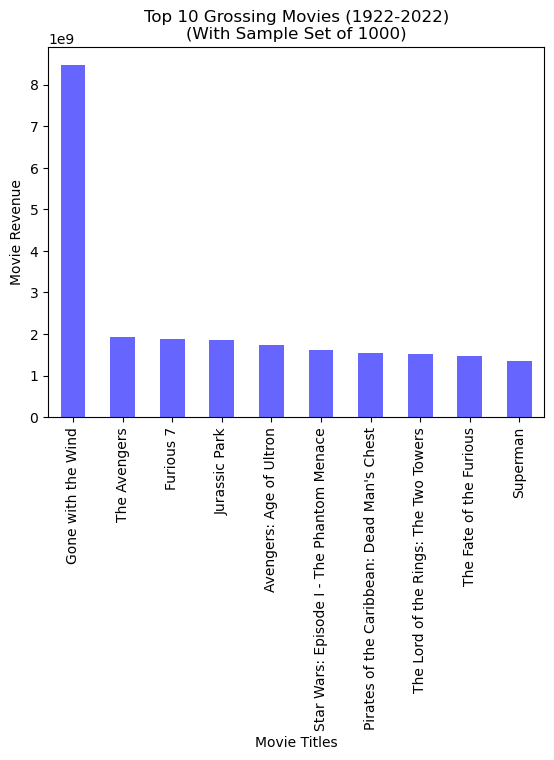

In [110]:
# Create a bar chart to display top 10 grossing movies

top_ten_df.plot("Title", "infl_adj_revenue", kind='bar', alpha=0.6, color='blue', title="Top 10 Grossing Movies (1922-2022)\n(With Sample Set of 1000)",
                xlabel="Movie Titles", ylabel="Movie Revenue", legend='')


# ax=top_ten_df.plot("Title", "revenue", kind='bar', alpha=0.6, color='blue', title="Top 10 Grossing Movies (1922-2022)",
#                 xlabel="Movie Titles", ylabel="Movie Revenue", legend='')
# ax.set_xticklabels(top_ten_df['Title'], rotation=45)
# plt.show()


plt.savefig("Output/Top 10 Grossing Movies.png", bbox_inches='tight')

In [50]:
country_df = movie_list.copy(deep=True)
country_df[['country1', 'country2', 'country3', 'country4', 'country5', 'country6']] = country_df['production_countries'].str.split(', ', expand=True, n=5)
country_df.sample(10)

,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,...,infl_adj_budget,infl_adj_revenue,real_profit,Decades,country1,country2,country3,country4,country5,country6
228,228,Spotlight,2015,314365,tt1895587,"Drama, History",129,20000000,98690254.0,"Canada, United States of America",...,24694853.111802,121857066.304822,9.716221e+07,2010s,Canada,United States of America,None,None,None,None
734,734,Black Lightning,2009,31162,tt1569364,"Science Fiction, Action, Adventure, Thriller",102,10000000,21500000.0,"Russia, United States of America",...,13641236.709752,29328658.925966,1.568742e+07,2000s,Russia,United States of America,None,None,None,None
523,523,Prom Night,1980,36599,tt0081383,"Horror, Mystery, Thriller",92,1500000,14796236.0,Canada,...,5327457.524272,52550879.206068,4.722342e+07,1970s,Canada,None,None,None,None,None
480,480,Cheaper by the Dozen 2,2005,9641,tt0452598,"Comedy, Family, Adventure",94,60000000,129181830.0,"Canada, United States of America",...,89909370.199693,193577616.27573,1.036682e+08,2000s,Canada,United States of America,None,None,None,None
810,810,Things to Do in Denver When You're Dead,1995,400,tt0114660,"Drama, Crime",116,8000000,529766.0,United States of America,...,15362467.191601,1017314.099278,-1.434515e+07,1990s,United States of America,None,None,None,None,None
361,361,Dirty Grandpa,2016,291870,tt1860213,Comedy,102,11500000,94073028.0,United States of America,...,14022643.089577,114708912.69563,1.006863e+08,2010s,United States of America,None,None,None,None,None
673,673,Blood Ties,2013,190955,tt1747958,"Thriller, Crime, Drama",128,25500000,2415472.0,"France, United States of America",...,32034678.073636,3034465.408466,-2.900021e+07,2010s,France,United States of America,None,None,None,None
400,400,Pocketful of Miracles,1961,248,tt0055312,"Comedy, Drama",136,2900000,5000000.0,United States of America,...,28384598.662207,48938963.210702,2.055436e+07,1960s,United States of America,None,None,None,None,None
687,687,Harry Potter and the Deathly Hallows: Part 1,2010,12444,tt0926084,"Adventure, Fantasy",146,250000000,954305868.0,"United Kingdom, United States of America",...,335527341.600323,1280782843.854514,9.452555e+08,2000s,United Kingdom,United States of America,None,None,None,None
500,500,The Avengers,2012,24428,tt0848228,"Science Fiction, Action, Adventure",143,220000000,1518815515.0,United States of America,...,280425882.209465,1935978094.124084,1.655552e+09,2010s,United States of America,None,None,None,None,None


In [51]:
country_df2 = country_df.sort_values(by='infl_adj_revenue', ascending=False)
country_df3 = country_df2.iloc[0:50, :]
country_df3

,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,...,infl_adj_budget,infl_adj_revenue,real_profit,Decades,country1,country2,country3,country4,country5,country6
710,710,Gone with the Wind,1939,770,tt0031381,"Drama, War, Romance",238,4000000,402352579.0,United States of America,...,84217266.18705,8471258561.672301,8.387041e+09,1930s,United States of America,None,None,None,None,None
500,500,The Avengers,2012,24428,tt0848228,"Science Fiction, Action, Adventure",143,220000000,1518815515.0,United States of America,...,280425882.209465,1935978094.124084,1.655552e+09,2010s,United States of America,None,None,None,None,None
591,591,Furious 7,2015,168259,tt2820852,"Action, Thriller, Crime",137,190000000,1515341399.0,United States of America,...,234601104.56212,1871056663.126885,1.636456e+09,2010s,United States of America,None,None,None,None,None
834,834,Jurassic Park,1993,329,tt0107290,"Adventure, Science Fiction",127,63000000,920100000.0,United States of America,...,127593529.411765,1863473117.647059,1.735880e+09,1990s,United States of America,None,None,None,None,None
34,34,Avengers: Age of Ultron,2015,99861,tt2395427,"Action, Adventure, Science Fiction",141,365000000,1405403694.0,United States of America,...,450681069.290388,1735311889.305704,1.284631e+09,2010s,United States of America,None,None,None,None,None
183,183,Star Wars: Episode I - The Phantom Menace,1999,1893,tt0120915,"Adventure, Action, Science Fiction",136,115000000,924317558.0,United States of America,...,202012755.102041,1623686404.180612,1.421674e+09,1990s,United States of America,None,None,None,None,None
97,97,Pirates of the Caribbean: Dead Man's Chest,2006,58,tt0383574,"Adventure, Fantasy, Action",151,200000000,1065659812.0,United States of America,...,290332341.269841,1546977541.075694,1.256645e+09,2000s,United States of America,None,None,None,None,None
311,311,The Lord of the Rings: The Two Towers,2002,121,tt0167261,"Adventure, Fantasy, Action",179,79000000,926287400.0,"New Zealand, United States of America",...,128514424.680378,1506851801.261812,1.378337e+09,2000s,New Zealand,United States of America,None,None,None,None
892,892,The Fate of the Furious,2017,337339,tt4630562,"Action, Crime, Thriller",136,250000000,1236005118.0,United States of America,...,298481356.070496,1475697934.922854,1.177217e+09,2010s,United States of America,None,None,None,None,None
249,249,Superman,1978,1924,tt0078346,"Science Fiction, Action, Adventure",143,55000000,300218018.0,"Panama, Switzerland, United Kingdom, United St...",...,246871549.079755,1347550675.732975,1.100679e+09,1970s,Panama,Switzerland,United Kingdom,United States of America,None,None


In [52]:
countries = list(country_df3["country1"].unique())
countries

['United States of America',
 'New Zealand',
 'Panama',
 'United Kingdom',
 'Canada',
 'Czech Republic']

In [53]:
# # MAP TIME
# # Import dependencies needed for world map visualizations
import matplotlib.pyplot as plt
import hvplot.pandas
import geoviews
import geopandas 

# Load the world map GeoDataFrame
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# Filter the GeoDataFrame to select the list of top 10 grossing films' production countries

country_data = []
for i in range(len(countries)):
    country_data.append(world[world['name'] == countries[i]])

# Print the USA GeoDataFrame
print(country_data)

[     pop_est      continent                      name iso_a3  gdp_md_est  \
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  ,      pop_est continent         name iso_a3  gdp_md_est  \
136  4510327   Oceania  New Zealand    NZL    174800.0   

                                              geometry  
136  MULTIPOLYGON (((176.88582 -40.06598, 176.50802...  ,     pop_est      continent    name iso_a3  gdp_md_est  \
33  3753142  North America  Panama    PAN     93120.0   

                                             geometry  
33  POLYGON ((-77.35336 8.67050, -77.47472 8.52429...  ,       pop_est continent            name iso_a3  gdp_md_est  \
143  64769452    Europe  United Kingdom    GBR   2788000.0   

                                              geometry  
143  MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...  ,     pop_est      continent    name 

/Users/carterjackson/anaconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/carterjackson/anaconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/carterjackson/anaconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/carterjackson/anaconda3/lib/python3.11/site-packages/geopandas/plo

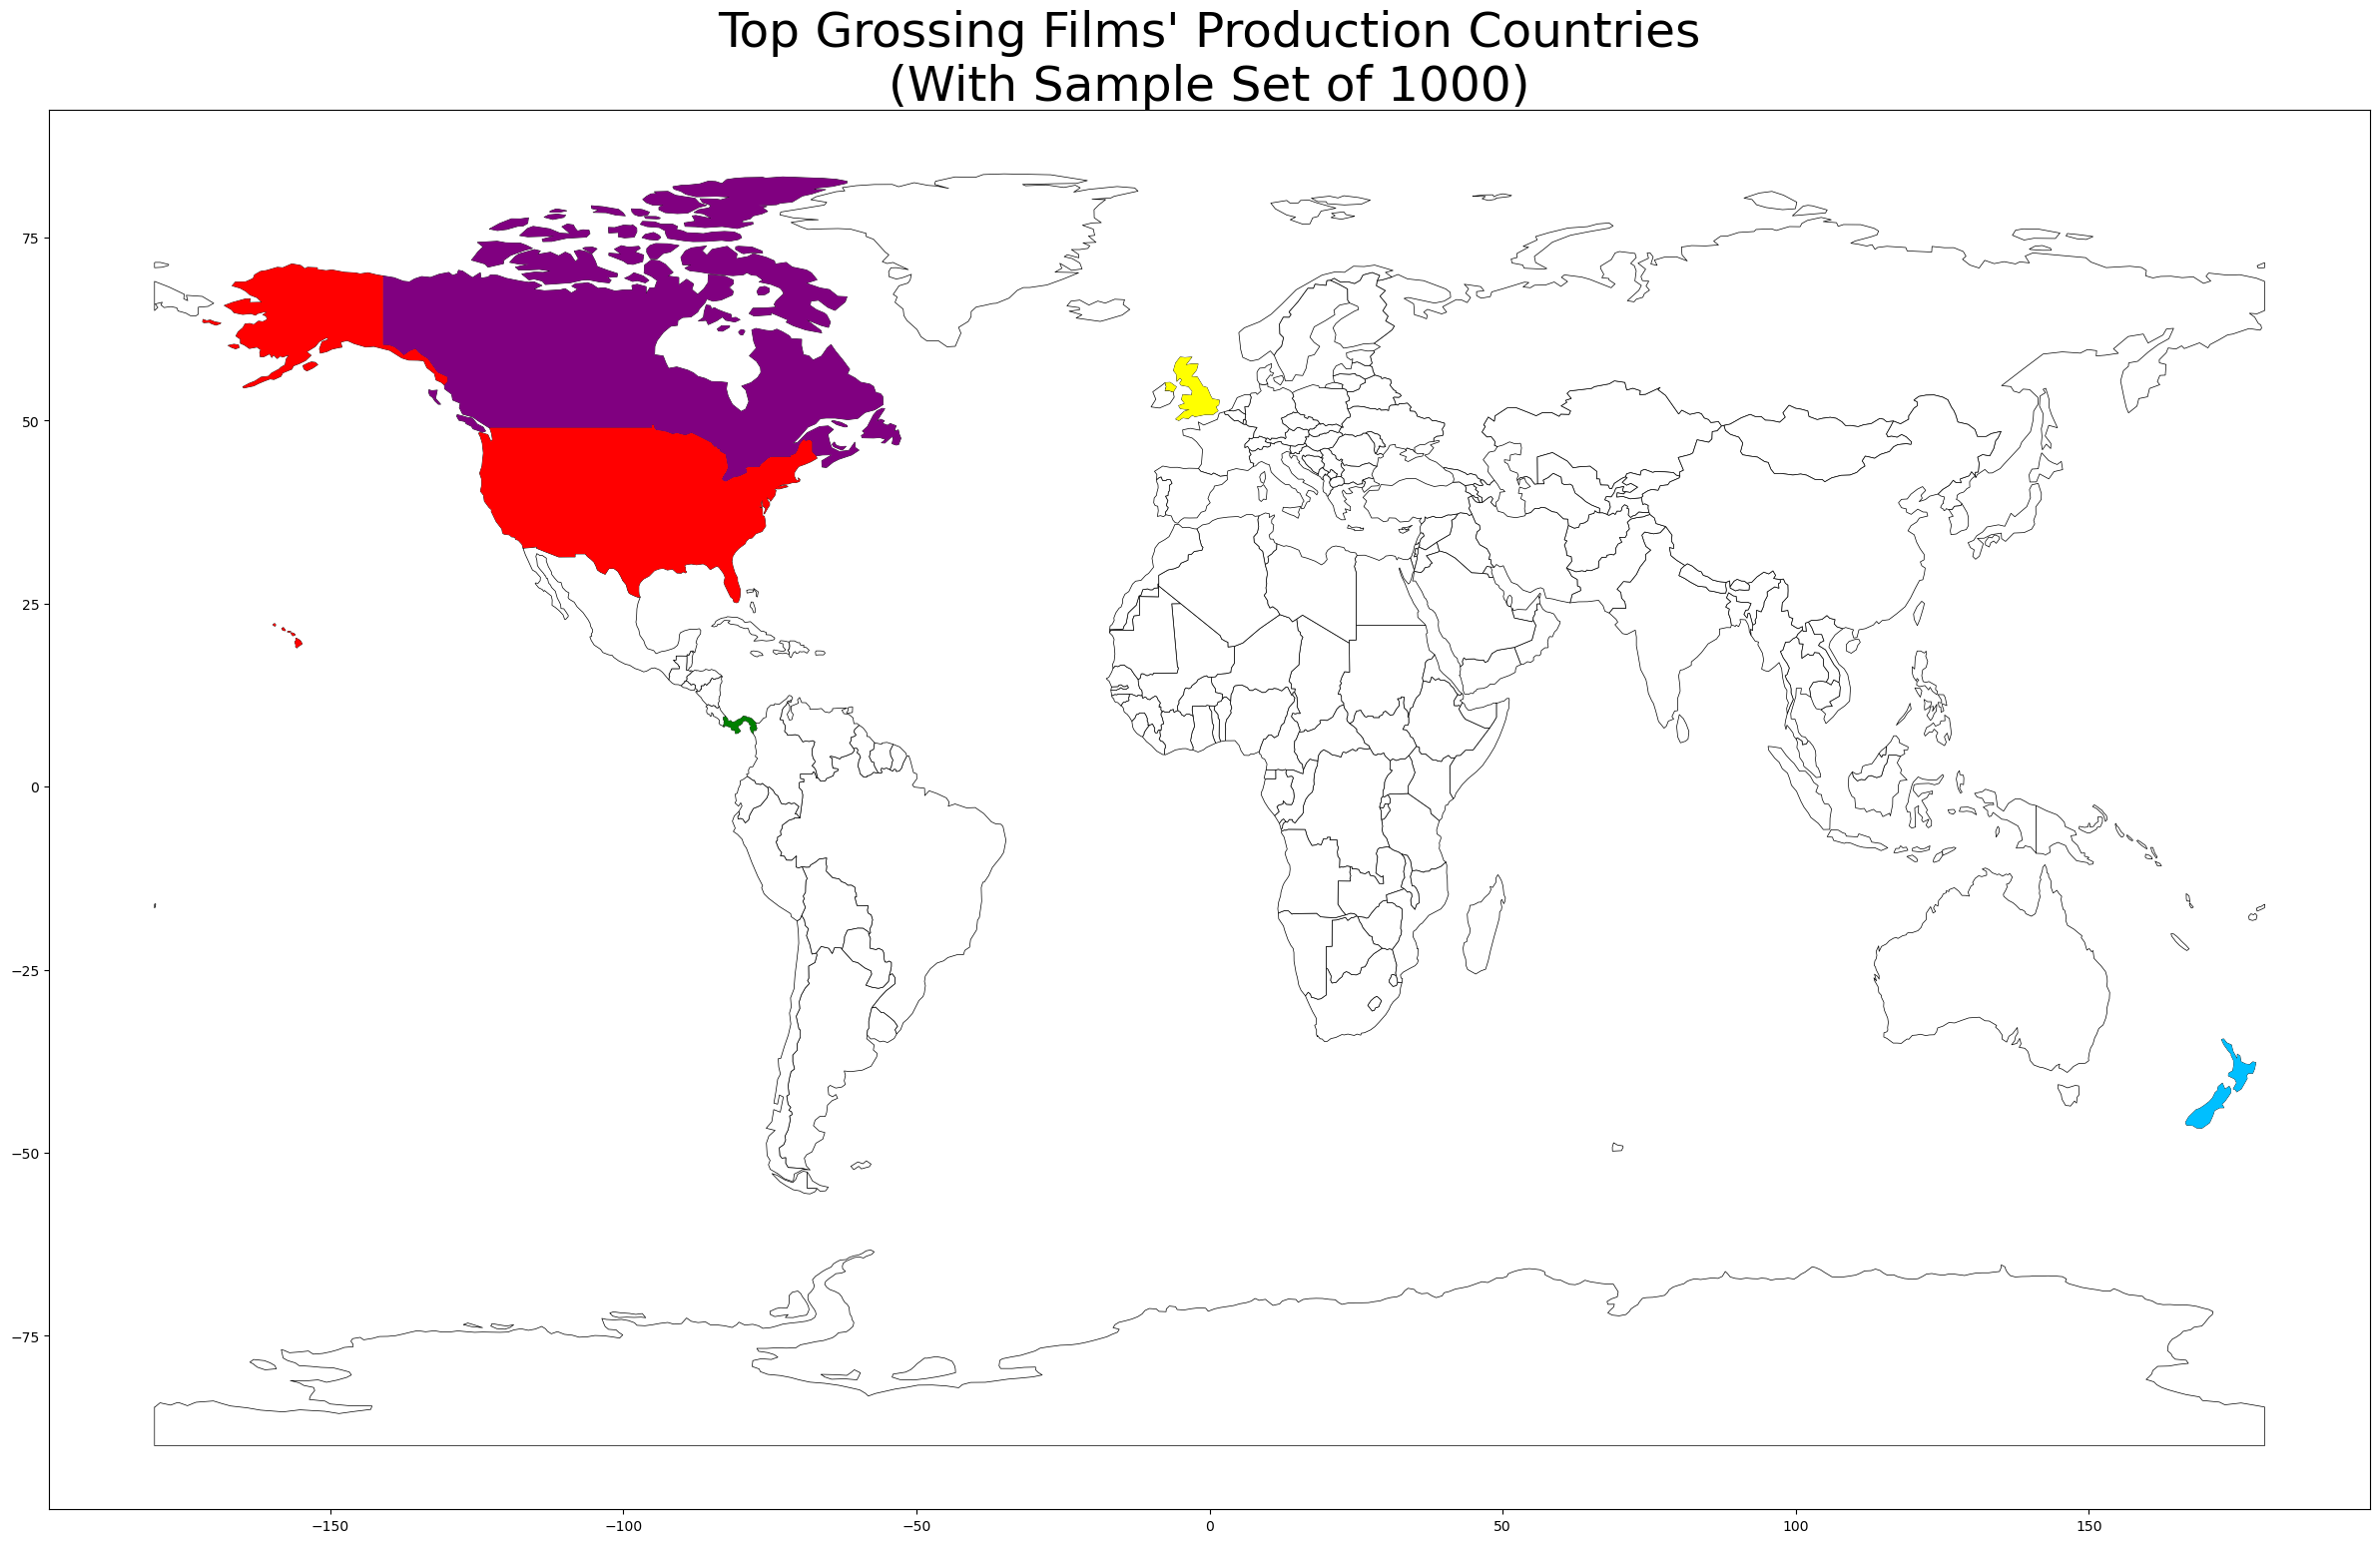

In [115]:
# Create a base world map
world.plot(color='w', figsize=(30, 20), edgecolor='black', aspect="auto", linewidth=0.5)

# Extract the indices
# indices = [index for index, word in indexed_list]

# Create a list of colors to be looped through when plotting the list of countries
colors = ['red', 'deepskyblue', 'green', 'yellow', 'purple', 'orange', 'pink', 'cyan', 'peachpuff', 'gold', 
          'firebrick', 'darkturquoise', 'blueviolet', 'maroon']

for i in range(len(country_data)):
    current_color = colors[i % len(colors)] 
    country_data[i].plot(color=current_color, alpha=1, aspect='1.25', ax=plt.gca())

plt.title(f"Top Grossing Films' Production Countries\n(With Sample Set of 1000)", fontsize=35)
plt.savefig("Output/Top Grossing Films Coutries.png", bbox_inches='tight')
plt.show()

In [55]:
# # Create a base world map
# world.plot(color='w', figsize=(30, 20), edgecolor='black', aspect="auto", linewidth=0.5)

# # Assign ascending indices to the length of the list
# indexed_list = list(enumerate(countries))

# # Extract the indices
# indices = [index for index, word in indexed_list]

# # Plot the United States in a different color

# for i in range(len(country_data)):
#     for_alpha=(0.1*float(indices[i]))+0.2
#     country_data[i].plot(color='blue', alpha=for_alpha, aspect='1.25', ax=plt.gca())

# plt.show()

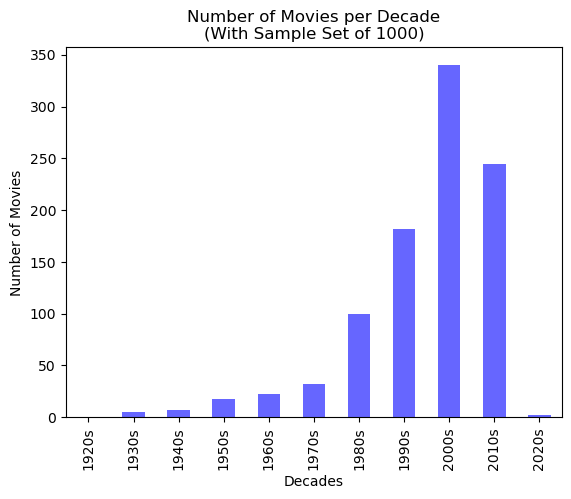

In [116]:
# Create a bar chart based upon the above data
y_axis=movie_list.groupby('Decades').count()['Title']
y_axis.plot(kind='bar', alpha=0.6, color='blue', title="Number of Movies per Decade\n(With Sample Set of 1000)", xlabel="Decades", ylabel="Number of Movies")
plt.savefig("Output/Number of Movies per Decade.png", bbox_inches='tight')

## Pie Chart

In [57]:
# Minimum Budget
min_budget = movie_list['infl_adj_budget'].min()
# Average Budget
avg_budget = movie_list['infl_adj_budget'].mean()
# Maximum Budget
max_budget = movie_list['infl_adj_budget'].max()
diff = (max_budget-min_budget)/3
# Define the bins and labels
bins=[min_budget,round(min_budget+diff),round(min_budget+2*diff),round(min_budget+3*diff)]
labels = ['Low Budget', 'Average Budget', 'High Budget']
# Cut the 'Budget' column into categories and create a new column 'Budget_Category'
movie_list['Budget_Category'] = pd.cut(movie_list['infl_adj_budget'], bins=bins, labels=labels)
movie_list.sample(10)

,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category
440,440,This Is Where I Leave You,2014,239678,tt1371150,"Drama, Comedy",103,19800000,41296320.0,United States of America,11.513,6.584,6.6,"86,811",24476923.6618,51050852.128954,2.657393e+07,2010s,Low Budget
470,470,Ernest Saves Christmas,1988,26386,tt0095107,"Comedy, Family",95,6000000,28202109.0,United States of America,8.927,5.271,5.7,"12,240",14843026.204565,69767440.485165,5.492441e+07,1980s,Low Budget
412,412,The Land Before Time,1988,12144,tt0095489,"Family, Animation, Adventure",69,12500000,84460846.0,"Ireland, United States of America",20.593,7.100,7.4,"95,511",30922971.25951,208942425.07295,1.780195e+08,1980s,Low Budget
707,707,Bad Santa 2,2016,338964,tt1798603,"Comedy, Crime, Drama, Mystery",92,26000000,24079268.0,United States of America,9.676,5.400,5.6,"27,294",31703366.98513,29361302.697588,-2.342064e+06,2010s,Low Budget
454,454,Broadway Danny Rose,1984,12762,tt0087003,Comedy,84,8000000,10600497.0,United States of America,7.319,7.200,7.4,"26,456",22533589.990375,29858406.636526,7.324817e+06,1980s,Low Budget
275,275,Sin City,2005,187,tt0401792,"Thriller, Action, Crime",124,40000000,158733820.0,United States of America,24.174,7.449,8.0,"785,278",59939580.133129,237860963.09319,1.779214e+08,2000s,Low Budget
826,826,Mad Max 2,1981,8810,tt0082694,"Adventure, Action, Thriller, Science Fiction",96,2000000,24600832.0,Australia,37.722,7.400,7.6,"188,800",6439053.905391,79203041.682728,7.276399e+07,1980s,Low Budget
937,937,Snitch,2013,134411,tt0882977,"Thriller, Drama, Action",112,35000000,42930462.0,"United States of America, United Arab Emirates",19.726,6.084,6.4,"91,598",43969165.983422,53931903.126371,9.962737e+06,2010s,Low Budget
343,343,Warm Bodies,2013,82654,tt1588173,"Horror, Comedy, Romance",97,35000000,116980662.0,United States of America,20.145,6.400,6.8,"239,352",43969165.983422,146958346.980816,1.029892e+08,2010s,Low Budget
429,429,The Shallows,2016,332567,tt4052882,"Horror, Drama, Thriller",86,17000000,119100758.0,"Australia, Spain, United States of America",17.987,6.349,6.3,"140,654",20729124.5672,145226732.27235,1.244976e+08,2010s,Low Budget


  Budget_Category  count
0      Low Budget    872
1  Average Budget     73
2     High Budget      4


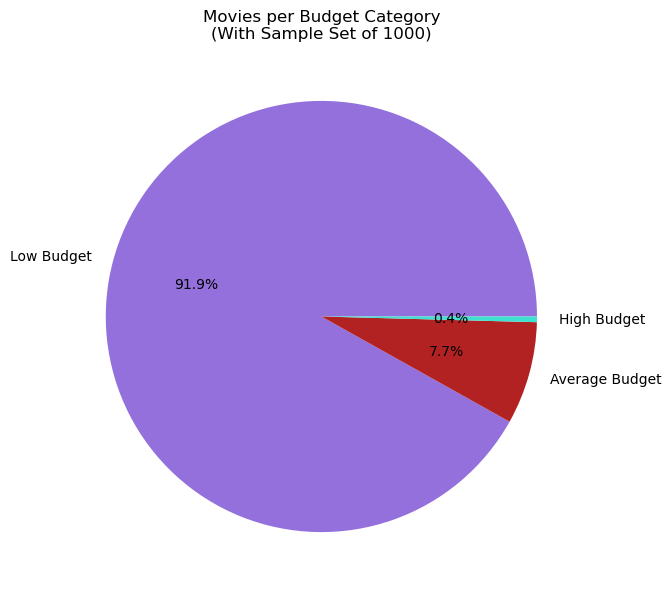

In [128]:
# Pie plot showing the distribution of Budget category using pyplot
budget_distribution = movie_list['Budget_Category'].value_counts().reset_index()
print(budget_distribution)
#create y label
y = [budget_distribution['count'][0],budget_distribution['count'][1],budget_distribution['count'][2]]
#Show Pie Plot
plt.figure(figsize=(10,7))
plt.title("Movies per Budget Category\n(With Sample Set of 1000)")
plt.pie(y,autopct='%1.1f%%',labels=['Low Budget','Average Budget','High Budget'], colors=['mediumpurple', 'firebrick', 'turquoise'])
plt.savefig("Output/Movies per Budget Category.png", bbox_inches='tight')
plt.show()

In [59]:
genre_df = movie_list.copy(deep=True)
# genre_df
genre_df[['primary_genre', 'sub_genre_1', 'sub_genre_2', 'sub_genre_3', 'sub_genre_4', 'sub_genre_5']] = genre_df['genres'].str.split(', ', expand=True, n=5)
genre_df

,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,...,infl_adj_revenue,real_profit,Decades,Budget_Category,primary_genre,sub_genre_1,sub_genre_2,sub_genre_3,sub_genre_4,sub_genre_5
0,0,The Big Hit,1998,9448,tt0120609,"Action, Adventure, Comedy, Thriller",91,13000000,27007143.0,United States of America,...,48489419.844571,2.514884e+07,1990s,Low Budget,Action,Adventure,Comedy,Thriller,None,None
1,1,The Fault in Our Stars,2014,222935,tt2582846,"Romance, Drama",126,14000000,307166834.0,United States of America,...,379722179.15429,3.624153e+08,2010s,Low Budget,Romance,Drama,None,None,None,None
2,2,Drop Dead Gorgeous,1999,10490,tt0157503,Comedy,98,10000000,10571408.0,United States of America,...,18570080.481633,1.003754e+06,1990s,Low Budget,Comedy,None,None,None,None,None
3,3,Warlords of the 21st Century,1982,27873,tt0084887,"Science Fiction, Action, Adventure",91,1000000,3000000.0,New Zealand,...,9098082.901554,6.065389e+06,1980s,Low Budget,Science Fiction,Action,Adventure,None,None,None
4,4,Dave Chappelle's Block Party,2005,292,tt0425598,"Comedy, Documentary, Music",100,3000000,11718595.0,United States of America,...,17560191.601254,1.306472e+07,2000s,Low Budget,Comedy,Documentary,Music,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,946,The Hunger Games: Mockingjay - Part 1,2014,131631,tt1951265,"Science Fiction, Adventure, Thriller",123,125000000,755356711.0,"Canada, United States of America",...,933778209.726045,7.792522e+08,2010s,Average Budget,Science Fiction,Adventure,Thriller,None,None,None
947,947,Morning Glory,2010,38357,tt1126618,"Drama, Comedy, Romance",107,40000000,60040976.0,United States of America,...,80581556.257475,2.689718e+07,2000s,Low Budget,Drama,Comedy,Romance,None,None,None
948,948,Death Wish 3,1985,24873,tt0089003,"Action, Crime, Drama",92,9000000,16116878.0,United States of America,...,43835361.813104,1.935678e+07,1980s,Low Budget,Action,Crime,Drama,None,None,None
949,949,The Last Exorcism,2010,38358,tt1320244,"Horror, Thriller, Mystery",87,1800000,69432527.0,"United States of America, France",...,93186044.819611,9.077025e+07,2000s,Low Budget,Horror,Thriller,Mystery,None,None,None


In [60]:

# colors = plt.cm.Paired(range(len(primary_genre)))
primary_genre = genre_df['primary_genre'].value_counts()
primary_genre_length = len(primary_genre)

# Make blank list for explode values and loop through the primary genre length to append 0 after 0.1 accordingly
explode = []
for i in range(primary_genre_length):
    if i == 0:
        explode.append(0.1)
    else:
        explode.append(0)
print(f"Number of primary genres: {len(primary_genre)}")
primary_genre

Number of primary genres: 18


primary_genre
Drama              228
Comedy             197
Action             136
Adventure           75
Horror              59
Thriller            44
Crime               36
Science Fiction     29
Romance             26
Animation           25
Fantasy             24
Family              22
Mystery             16
Western             10
War                  9
Documentary          7
Music                5
History              3
Name: count, dtype: int64

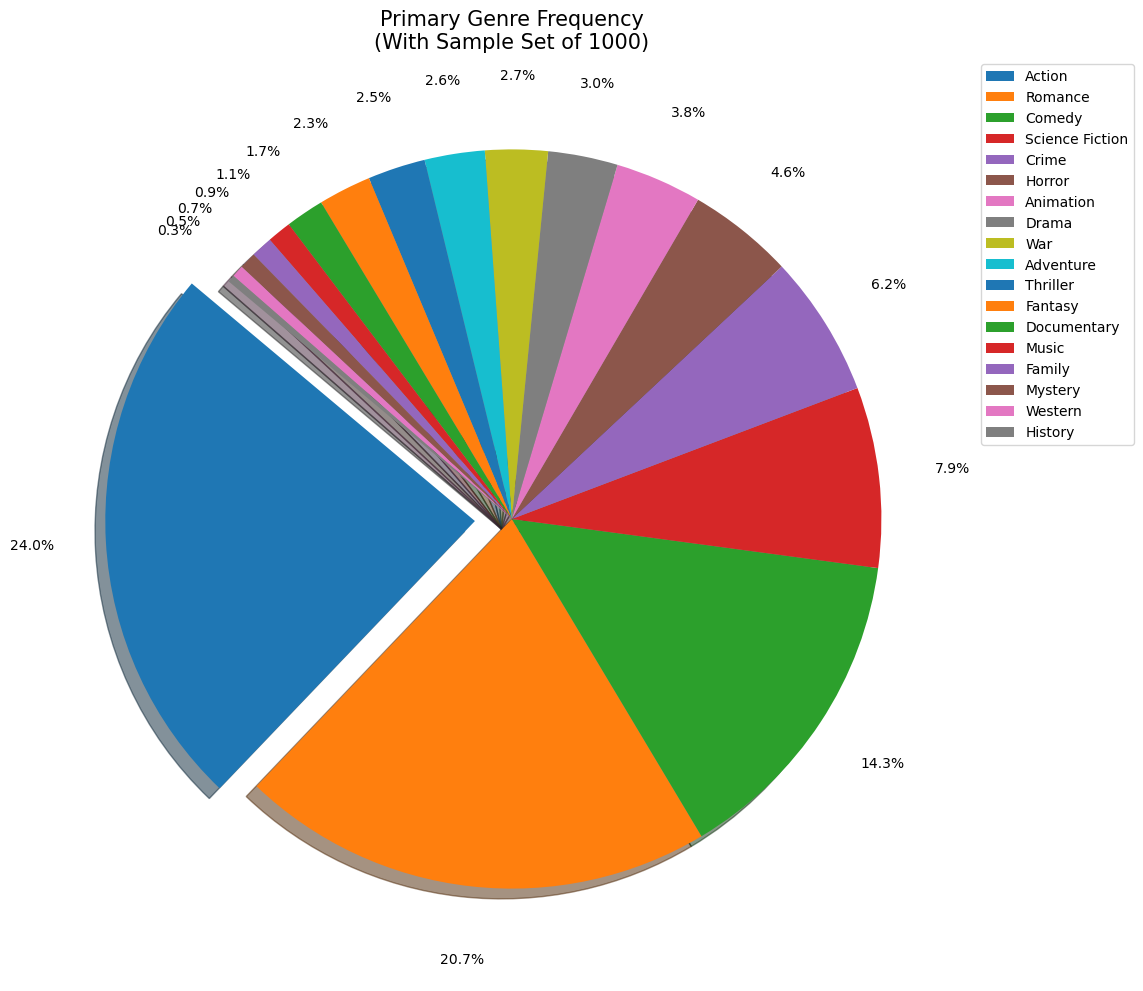

In [130]:
plt.figure(figsize=(12, 12))
categories = genre_df['primary_genre'].unique()
# This code would be to include 'exploding' the biggest value out but has an error when 'explode' list is not equal
# to length of primary genres
plt.pie(primary_genre, autopct= "%1.1f%%", shadow=True, startangle=140, pctdistance=1.2, explode=explode)
# plt.pie(primary_genre, autopct= "%1.1f%%", shadow=True, startangle=140, pctdistance=1.2)
plt.legend(categories, loc='best', bbox_to_anchor=(1, 1))
plt.title('Primary Genre Frequency\n(With Sample Set of 1000)', fontsize=15)
plt.savefig("Output/Primary Genre Frequency.png", bbox_inches='tight')
plt.show()

## Bar Plot

<Figure size 1000x200 with 0 Axes>

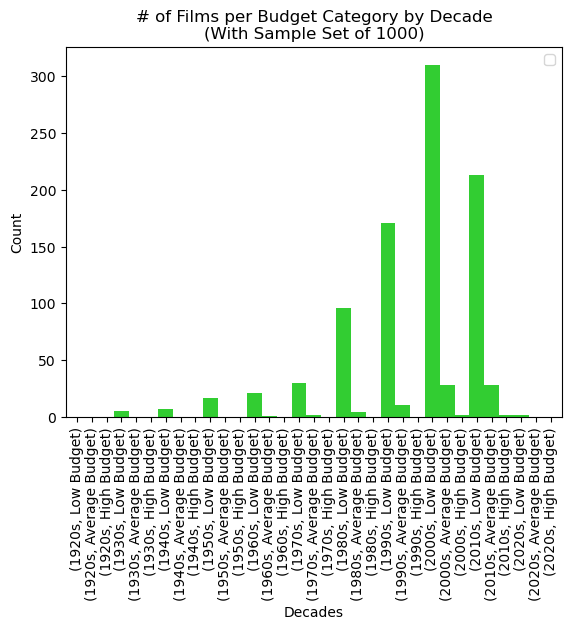

In [137]:
#Bar plot Budget Categories by Decades
grouped_df = movie_list.groupby(['Decades', 'Budget_Category'])['Title'].count().reset_index()
pivot_df=grouped_df.set_index(['Decades', 'Budget_Category'])
# Set the figure size
plt.figure(figsize=(10,2))  # Width, Height in inches
# Create a stacked bar plot
pivot_df.plot(kind='bar',width=1,color=['limegreen', 'orange', 'deepskyblue'], stacked=True)
# Add labels and a title
plt.xlabel('Decades')
plt.ylabel('Count')
plt.title('# of Films per Budget Category by Decade\n(With Sample Set of 1000)')
plt.legend("")
# Show the plot
plt.savefig("Output/Films per Budget Category by Decade.png", bbox_inches='tight')
plt.show()

## Histogram Plotting

In [ ]:
\n(With Sample Set of 1000)
plt.savefig("Output/Top 10 Grossing Movies.png", bbox_inches='tight')

Text(0.5, 1.0, 'Histogram of Budget')

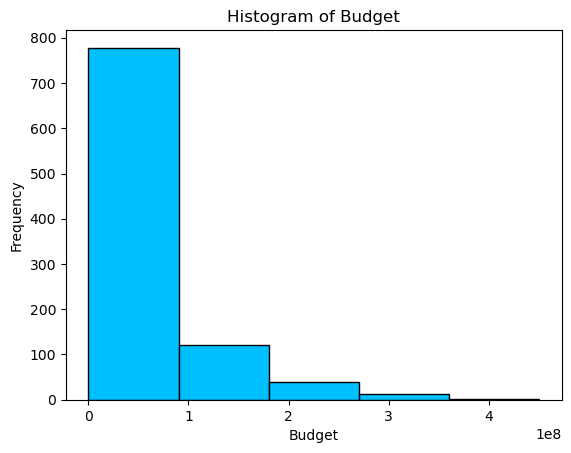

In [63]:
# Plot a histogram of budget
plt.hist(movie_list['infl_adj_budget'],bins=5, color='deepskyblue', edgecolor='k')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.title('Histogram of Budget')

In [64]:
# 
from scipy.stats import shapiro
DataToTest = movie_list['infl_adj_budget']
stat,p = shapiro(DataToTest)
print(f"stat: {stat},p: {p}")
if(p>0.05):
    print("Accept NULL Hypothesis: Budget data is not normally Distributed")
else:
    print("Reject NULL Hypothesis: Budget data is not normally Distributed")

stat: 0.7776381373405457,p: 5.053869443224975e-34
Reject NULL Hypothesis: Budget data is not normally Distributed


## Scatter Plots with Linear Regression

In [94]:
# Creating a function for computing linear regression
def lin_regress(xval, yval, x_label, y_label): 
    x_values = xval
    y_values = yval
    
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_values,y_values, c='blueviolet')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,(10,20),fontsize=15,color="red")
    plt.legend(['Regression Line: y = {:.2f}x + {:.2f}'.format(slope, intercept)])
    print("The r-value is: ",rvalue)
    print(f"Slope: {slope}, Intercept: {intercept}")
    plt.show()
#     x_values = 0
#     y_values = 0

The r-value is:  -0.04285644069316508
Slope: -0.06349368457398781, Intercept: 238.4272909943723


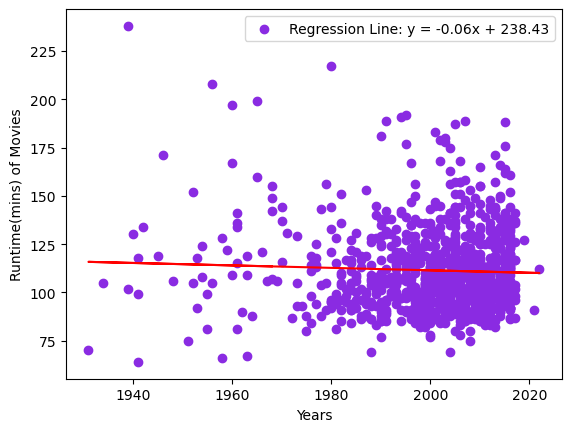

In [95]:
# Create a scatter plot for regression analysis

xval = movie_list['Year']
yval = movie_list['runtime'].astype(int)
x_label='Years'
y_label='Runtime(mins) of Movies'

lin_regress(xval, yval, x_label, y_label)

The r-value is:  0.10336457360114276
Slope: 1.4629583535966514e-09, Intercept: 6.407959225140689


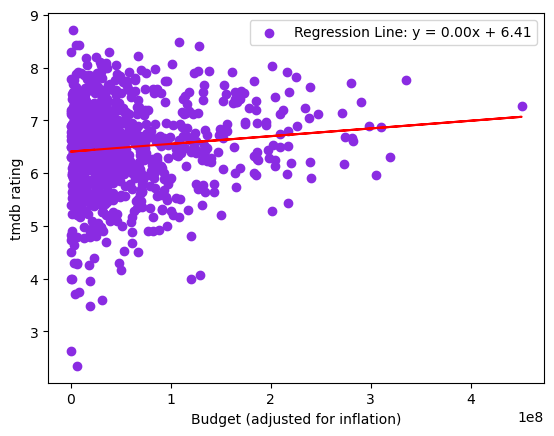

In [96]:
# Create a scatter plot for regression analysis: Budget vs. tmdb

xval = movie_list['infl_adj_budget'].astype(int)
yval = movie_list['tmdb_rating'].astype(float)
x_label='Budget (adjusted for inflation)'
y_label='tmdb rating'

lin_regress(xval, yval, x_label, y_label)

In [97]:
movie_list['imdb_rating'].unique()

array([6. , 7.7, 6.7, 5. , 7.2, 6.2, 6.4, 7. , 5.4, 8.1, 5.6, 6.8, 7.3,
       6.6, 6.5, 5.8, 7.1, 5.5, 6.3, 7.5, 6.9, 7.6, 7.4, 4.8, 8.4, 8. ,
       4.7, 5.3, 8.8, 5.9, 5.7, 4.6, 7.9, 5.1, 7.8, 4.4, 6.1, 3.7, 2.1,
       4.2, 8.2, 2.9, 4. , 5.2, 4.9, 4.3, 3.8, 8.5, 8.6, 4.5, 3.6, 1.8,
       8.3, 4.1, 3.5, 2.2, 2.6, 1.9, 3.3])

The r-value is:  0.06087334025503215
Slope: 1.0175048862474973e-09, Intercept: 6.484388894185457


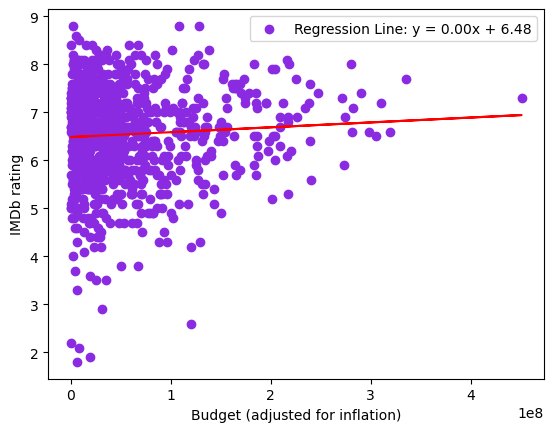

In [98]:
# Create a scatter plot for regression analysis: Budget vs. imbd Rating

xval = movie_list['infl_adj_budget'].astype(int)
yval = movie_list['imdb_rating'].astype(float)
x_label='Budget (adjusted for inflation)'
y_label='IMDb rating'

lin_regress(xval, yval, x_label, y_label)

The r-value is:  0.22912901057629528
Slope: 5.974186726917406e-10, Intercept: 6.432842629637336


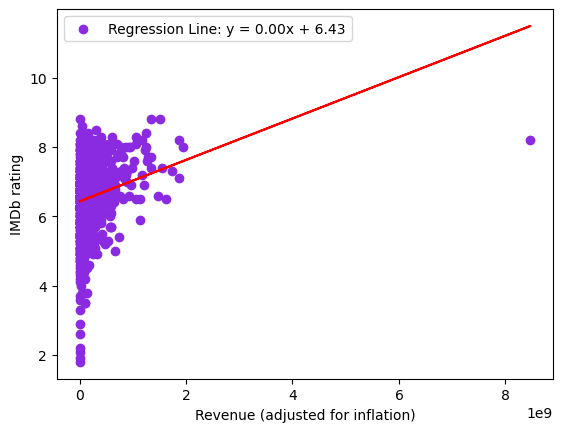

In [99]:
# Create a scatter plot for regression analysis: Revenue vs. imbd Rating

xval = movie_list['infl_adj_revenue'].astype(float)
yval = movie_list['imdb_rating'].astype(float)
x_label='Revenue (adjusted for inflation)'
y_label='IMDb rating'

lin_regress(xval, yval, x_label, y_label)

The r-value is:  0.32848038168227145
Slope: 1.880909261108446e-08, Intercept: 108.08928906761481


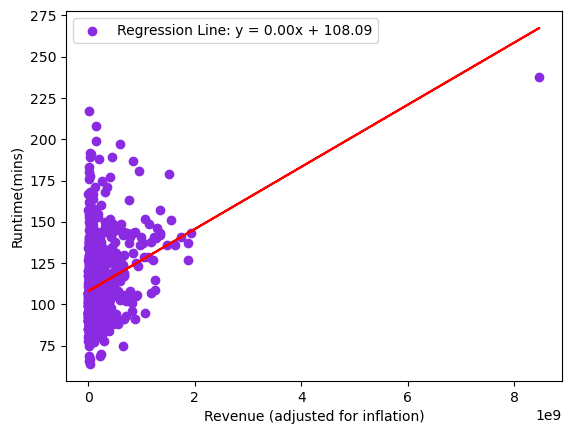

In [100]:
# Create a scatter plot for regression analysis: Revenue vs. Runtime

xval = movie_list['infl_adj_revenue'].astype(float)
yval = movie_list['runtime'].astype(int)
x_label='Revenue (adjusted for inflation)'
y_label='Runtime(mins)'

lin_regress(xval, yval, x_label, y_label)

# Data Testing

## 

In [72]:
#TEST NULL HYPOTHESIS(budget and revenue)
#H0: There is a significant association between budget and revenue of a movie.
#H1: There is no significant association between budget and revenue of a movie
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(movie_list['infl_adj_budget'], movie_list['infl_adj_revenue'])

# Perform the chi-square test for independence
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)

alpha = 0.05  # Significance level

if p < alpha:
    print("Accept Null Hypothesis: There is no significant association between budget and revenue of a movie.")
else:
    print("Reject Null Hypothesis: There is no significant association between budget and revenue of a movie.")

Chi-Square Statistic: 761751.0000000012
P-value: 0.025682681043403294
Accept Null Hypothesis: There is no significant association between budget and revenue of a movie.


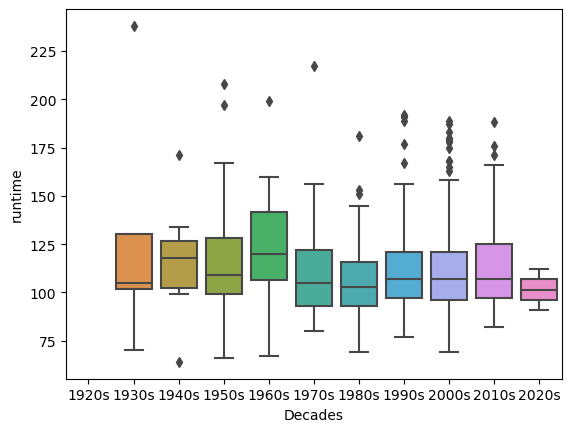

In [73]:
#Identifying Outliers in Movie Runtimes Over the Years
import seaborn as sns
ax = sns.boxplot(x='Decades',y='runtime',data=movie_list)

# Incorporating Oscar and Golden Globe Data

### Oscar dataset import and cleaning

In [74]:
# Import the Oscar csv to analyze
oscar_list = pd.read_csv("the_oscar_award.csv")
print(oscar_list.shape)
oscar_list.head(2)

(10765, 7)


,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True


In [75]:
# Check for NaN values in the film column of the Oscar List
oscar_list["film"].isnull().value_counts()

film
False    10450
True       315
Name: count, dtype: int64

In [76]:
# Drop the NaN values and the "False" winners to clean the data
oscar_list.dropna(how="any", inplace=True)
oscar_winners = oscar_list["winner"]==True

oscars = oscar_list[oscar_winners]
print(oscars.shape)
oscars

(2149, 7)


,year_film,year_ceremony,ceremony,category,name,film,winner
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
6,1927,1928,1,ART DIRECTION,William Cameron Menzies,The Dove;,True
9,1927,1928,1,CINEMATOGRAPHY,Charles Rosher,Sunrise,True
10,1927,1928,1,CINEMATOGRAPHY,Karl Struss,Sunrise,True
...,...,...,...,...,...,...,...
10743,2022,2023,95,SOUND,"Mark Weingarten, James H. Mather, Al Nelson, C...",Top Gun: Maverick,True
10745,2022,2023,95,VISUAL EFFECTS,"Joe Letteri, Richard Baneham, Eric Saindon and...",Avatar: The Way of Water,True
10753,2022,2023,95,WRITING (Adapted Screenplay),Screenplay by Sarah Polley,Women Talking,True
10755,2022,2023,95,WRITING (Original Screenplay),Written by Daniel Kwan & Daniel Scheinert,Everything Everywhere All at Once,True


In [77]:
# Count the number of wins each film has and turn that series into a DataFrame
oscar_wins = oscars[["film", "year_film"]].value_counts()
oscar_win_df = oscar_wins.reset_index()
oscar_win_df

,film,year_film,count
0,Titanic,1997,11
1,Ben-Hur,1959,11
2,The Lord of the Rings: The Return of the King,2003,11
3,West Side Story,1961,10
4,The Last Emperor,1987,9
...,...,...,...
1325,Knighty Knight Bugs,1958,1
1326,Kokoda Front Line!,1942,1
1327,Kolya,1996,1
1328,Kon-Tiki,1951,1


In [78]:
# Rename the columns of the DataFrame to cleanly merge with the movie data
oscar_win_df = oscar_win_df.rename(columns={'film': 'Title', 'year_film': 'Year', 'count': 'Oscar_Wins'})
oscar_win_df

,Title,Year,Oscar_Wins
0,Titanic,1997,11
1,Ben-Hur,1959,11
2,The Lord of the Rings: The Return of the King,2003,11
3,West Side Story,1961,10
4,The Last Emperor,1987,9
...,...,...,...
1325,Knighty Knight Bugs,1958,1
1326,Kokoda Front Line!,1942,1
1327,Kolya,1996,1
1328,Kon-Tiki,1951,1


### Golden Globe dataset import and cleaning

In [79]:
# Import the golden globes csv to analyze
gglobe_list = pd.read_csv("golden_globe_awards.csv")
print(gglobe_list.shape)
gglobe_list.head()

# gglobe_list

(7991, 7)


,year_film,year_award,ceremony,category,nominee,film,win
0,1943,1944,1,Best Performance by an Actress in a Supporting...,Katina Paxinou,For Whom The Bell Tolls,True
1,1943,1944,1,Best Performance by an Actor in a Supporting R...,Akim Tamiroff,For Whom The Bell Tolls,True
2,1943,1944,1,Best Director - Motion Picture,Henry King,The Song Of Bernadette,True
3,1943,1944,1,Picture,The Song Of Bernadette,NaN,True
4,1943,1944,1,Actress In A Leading Role,Jennifer Jones,The Song Of Bernadette,True


In [80]:
# Check for NaN values in the film column of the Golden Globe List
gglobe_list["film"].isnull().value_counts()

film
False    6191
True     1800
Name: count, dtype: int64

In [81]:
# Drop the NaN values and the "False" winners to clean the data
# gglobe_list.dropna(how="any", inplace=True)
gglobe_winners = gglobe_list["win"]==True
# gglobe_winners
gglobes = gglobe_list[gglobe_winners]

# Update the 'film' column where it is NaN with values from the 'nominee' column
gglobes['film'] = gglobes['film'].fillna(gglobes['nominee'])
gglobes.sample(10)

# print(gglobes.shape)
# gglobes

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_96556/1505913114.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gglobes['film'] = gglobes['film'].fillna(gglobes['nominee'])


,year_film,year_award,ceremony,category,nominee,film,win
7372,2015,2016,73,Best Performance by an Actor in a Motion Pictu...,Leonardo DiCaprio,The Revenant,True
3284,1982,1983,40,Best Performance by an Actress in a Television...,Debbie Allen,Fame,True
2283,1974,1975,32,Henrietta Award (World Film Favorites),Barbra Streisand,Barbra Streisand,True
2915,1979,1980,37,New Star Of The Year - Actor,Ricky/Rick Schroder,"Champ, The",True
7726,2017,2018,75,Best Performance by an Actress in a Supporting...,Laura Dern,Big Little Lies,True
7357,2015,2016,73,Best Motion Picture - Drama,The Revenant,The Revenant,True
3657,1985,1986,43,Best Performance by an Actor in a Limited Seri...,Dustin Hoffman,Death of a Salesman,True
3924,1987,1988,45,Best Performance by an Actor In A Television S...,Richard Kiley,"Year in the Life, A",True
1270,1966,1967,24,New Star Of The Year - Actor,James Farentino,"Pad, The",True
2712,1978,1979,36,Best Screenplay - Motion Picture,Oliver Stone,Midnight Express,True


In [83]:
# Count the number of wins each film has and turn that series into a DataFrame
gglobe_count = gglobes[["film", "year_film"]].value_counts()
gglobe_win_df = gglobe_count.reset_index()
gglobe_win_df

,film,year_film,count
0,La La Land,2016,7
1,Lawrence Of Arabia,1962,6
2,One Flew Over The Cuckoo's Nest,1975,6
3,Midnight Express,1978,6
4,Ordinary People,1980,5
...,...,...,...
1324,House,2006,1
1325,House of Cards,2013,1
1326,House of Cards,2014,1
1327,House of Lies,2012,1


In [84]:
# Rename the columns of the DataFrame to cleanly merge with the movie data
gglobe_win_df = gglobe_win_df.rename(columns={'film': 'Title', 'year_film': 'Year', 'count': 'Golden_Globe_Wins'})
gglobe_win_df

,Title,Year,Golden_Globe_Wins
0,La La Land,2016,7
1,Lawrence Of Arabia,1962,6
2,One Flew Over The Cuckoo's Nest,1975,6
3,Midnight Express,1978,6
4,Ordinary People,1980,5
...,...,...,...
1324,House,2006,1
1325,House of Cards,2013,1
1326,House of Cards,2014,1
1327,House of Lies,2012,1


## Merging the Oscars and Golden Globes DataFrames into the Movie List DataFrame

In [85]:
# Referencing the movie_list for ease of coding
print(movie_list.shape)
movie_list.head(1)

(951, 19)


,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category
0,0,The Big Hit,1998,9448,tt0120609,"Action, Adventure, Comedy, Thriller",91,13000000,27007143.0,United States of America,16.438,5.849,6.0,"31,038",23340582.822086,48489419.844571,2.514884e+07,1990s,Low Budget


In [86]:
# Individually merge the Oscars and Golden Globes DataFrames into the master movie list
oscar_awards = pd.merge(movie_list, oscar_win_df, how="inner", on=["Title", "Year"])
print(oscar_awards.shape)
oscar_awards.head()

(84, 20)


,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Oscar_Wins
0,10,The Best Years of Our Lives,1946,887,tt0036868,"Drama, Romance, War",171,2100000,23650000.0,United States of America,11.151,7.802,8.1,"68,614",31516692.307692,354937987.179487,3.234213e+08,1940s,Low Budget,7
1,25,Fargo,1996,275,tt0116282,"Crime, Drama, Thriller",98,7000000,60611975.0,"United Kingdom, United States of America",21.384,7.867,8.1,"704,045",13056628.425749,113055433.675112,9.999881e+07,1990s,Low Budget,2
2,39,Philadelphia,1993,9800,tt0107818,Drama,126,26000000,206678440.0,United States of America,28.284,7.725,7.7,"252,493",52657647.058824,418584628.776471,3.659270e+08,1990s,Low Budget,2
3,46,Raiders of the Lost Ark,1981,85,tt0082971,"Adventure, Action",115,18000000,389925971.0,United States of America,47.281,7.925,8.4,"1,014,633",57951485.148515,1255377173.190374,1.197426e+09,1980s,Low Budget,5
4,63,Forrest Gump,1994,13,tt0109830,"Comedy, Drama, Romance",142,55000000,677387716.0,United States of America,61.235,8.477,8.8,"2,183,967",108610155.195682,1337657908.407422,1.229048e+09,1990s,Low Budget,6


In [87]:
gglobe_awards = pd.merge(movie_list, gglobe_win_df, how="inner", on=["Title", "Year"])
print(gglobe_awards.shape)
gglobe_awards.head()

(48, 20)


,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Golden_Globe_Wins
0,39,Philadelphia,1993,9800,tt0107818,Drama,126,26000000,206678440.0,United States of America,28.284,7.725,7.7,"252,493",52657647.058824,418584628.776471,3.659270e+08,1990s,Low Budget,2
1,47,The Martian,2015,286217,tt3659388,"Drama, Adventure, Science Fiction",141,108000000,630600000.0,"United Kingdom, United States of America",39.703,7.679,8.0,"896,343",133352206.803731,778628718.61512,6.452765e+08,2010s,Low Budget,2
2,63,Forrest Gump,1994,13,tt0109830,"Comedy, Drama, Romance",142,55000000,677387716.0,United States of America,61.235,8.477,8.8,"2,183,967",108610155.195682,1337657908.407422,1.229048e+09,1990s,Low Budget,3
3,81,Misery,1990,1700,tt0100157,"Drama, Thriller",107,20000000,61276872.0,United States of America,24.816,7.756,7.8,"226,443",44782708.492731,137207214.806121,9.242451e+07,1980s,Low Budget,1
4,92,The Theory of Everything,2014,266856,tt2980516,"Drama, Romance",123,15000000,123726688.0,United Kingdom,28.077,7.860,7.7,"471,305",18543123.986212,152951954.399162,1.344088e+08,2010s,Low Budget,2


In [88]:
# Make a DataFrame merging Golden Globe Awards data onto the merged Oscar data to show only films with wins in both
both_awards = pd.merge(oscar_awards, gglobe_win_df, how="inner", on=["Title", "Year"])
print(both_awards.shape)
both_awards

(32, 21)


,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,...,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Oscar_Wins,Golden_Globe_Wins
0,39,Philadelphia,1993,9800,tt0107818,Drama,126,26000000,206678440.0,United States of America,...,7.725,7.7,"252,493",52657647.058824,418584628.776471,3.659270e+08,1990s,Low Budget,2,2
1,63,Forrest Gump,1994,13,tt0109830,"Comedy, Drama, Romance",142,55000000,677387716.0,United States of America,...,8.477,8.8,"2,183,967",108610155.195682,1337657908.407422,1.229048e+09,1990s,Low Budget,6,3
2,81,Misery,1990,1700,tt0100157,"Drama, Thriller",107,20000000,61276872.0,United States of America,...,7.756,7.8,"226,443",44782708.492731,137207214.806121,9.242451e+07,1980s,Low Budget,1,1
3,92,The Theory of Everything,2014,266856,tt2980516,"Drama, Romance",123,15000000,123726688.0,United Kingdom,...,7.860,7.7,"471,305",18543123.986212,152951954.399162,1.344088e+08,2010s,Low Budget,1,2
4,117,From Here to Eternity,1953,11426,tt0045793,"War, Romance, Drama",118,1650000,30500000.0,United States of America,...,7.303,7.6,"49,568",18085421.348315,334306273.40824,3.162209e+08,1950s,Low Budget,8,2
5,179,Some Like It Hot,1959,239,tt0053291,"Comedy, Romance, Crime",122,2883848,25000000.0,United States of America,...,8.100,8.2,"277,408",29002492.661168,251421821.305842,2.224193e+08,1950s,Low Budget,1,3
6,259,L.A. Confidential,1997,2118,tt0119488,"Crime, Mystery, Thriller",138,35000000,126216940.0,United States of America,...,7.800,8.2,"602,936",63818847.352025,230143417.917134,1.663246e+08,1990s,Low Budget,2,1
7,307,Chicago,2002,1574,tt0299658,"Comedy, Crime, Drama",113,45000000,306776732.0,"Germany, Canada, United States of America",...,7.112,7.2,"237,924",73204419.121734,499053610.35831,4.258492e+08,2000s,Low Budget,6,3
8,315,Unforgiven,1992,33,tt0105695,Western,130,14400000,159157447.0,United States of America,...,7.910,8.2,"426,855",30037291.518175,331990182.835246,3.019529e+08,1990s,Low Budget,4,2
9,337,Kramer vs. Kramer,1979,12102,tt0079417,Drama,105,8000000,106260000.0,United States of America,...,7.556,7.8,"151,535",32248484.848485,428340500.0,3.960920e+08,1970s,Low Budget,5,4


In [89]:
# Sum the Oscar and Golden Globe Award wins into a new column called cumulative awards
both_awards['Cumulative_Awards'] = ''
for index,row in both_awards.iterrows():
    both_awards.loc[index, "Cumulative_Awards"] = both_awards.loc[index,'Oscar_Wins']+both_awards.loc[index,'Golden_Globe_Wins']

both_awards.sort_values(by='Cumulative_Awards',ascending = False,inplace=True)
both_awards.head()

,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,...,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Oscar_Wins,Golden_Globe_Wins,Cumulative_Awards
23,706,On the Waterfront,1954,654,tt0047296,"Crime, Drama, Romance",108,910000,9600000.0,United States of America,...,8.1,"161,124",9900224.907063,104441933.085502,9.454171e+07,1950s,Low Budget,8,4,12
31,896,Shakespeare in Love,1998,1934,tt0138097,"Romance, History, Comedy",123,25000000,289317794.0,"United Kingdom, United States of America",...,7.1,"231,176",44885736.196319,519449687.135399,4.745640e+08,1990s,Low Budget,7,3,10
4,117,From Here to Eternity,1953,11426,tt0045793,"War, Romance, Drama",118,1650000,30500000.0,United States of America,...,7.6,"49,568",18085421.348315,334306273.40824,3.162209e+08,1950s,Low Budget,8,2,10
1,63,Forrest Gump,1994,13,tt0109830,"Comedy, Drama, Romance",142,55000000,677387716.0,United States of America,...,8.8,"2,183,967",108610155.195682,1337657908.407422,1.229048e+09,1990s,Low Budget,6,3,9
7,307,Chicago,2002,1574,tt0299658,"Comedy, Crime, Drama",113,45000000,306776732.0,"Germany, Canada, United States of America",...,7.2,"237,924",73204419.121734,499053610.35831,4.258492e+08,2000s,Low Budget,6,3,9
9,337,Kramer vs. Kramer,1979,12102,tt0079417,Drama,105,8000000,106260000.0,United States of America,...,7.8,"151,535",32248484.848485,428340500.0,3.960920e+08,1970s,Low Budget,5,4,9
18,651,Brokeback Mountain,2005,142,tt0388795,"Drama, Romance",134,14000000,178043761.0,"Canada, United States of America",...,7.7,"372,854",20978853.046595,266796706.991577,2.458179e+08,2000s,Low Budget,3,4,7
12,487,Driving Miss Daisy,1989,403,tt0097239,Drama,99,7500000,145793296.0,United States of America,...,7.3,"115,241",17700907.258065,344089814.845806,3.263889e+08,1980s,Low Budget,4,3,7
8,315,Unforgiven,1992,33,tt0105695,Western,130,14400000,159157447.0,United States of America,...,8.2,"426,855",30037291.518175,331990182.835246,3.019529e+08,1990s,Low Budget,4,2,6
13,493,Braveheart,1995,197,tt0112573,"Action, Drama, History, War",177,72000000,213216216.0,United States of America,...,8.3,"1,069,827",138262204.724409,409440890.377165,2.711787e+08,1990s,Low Budget,5,1,6


In [90]:
# Sort the data descending and grab the top 20 cumulative winners to do visualizations with
top20_both_awards = both_awards.sort_values(by='Cumulative_Awards', ascending=False)
top20_movies = top20_both_awards.iloc[0:20, :] 
top20_movies.head()

,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,...,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Oscar_Wins,Golden_Globe_Wins,Cumulative_Awards
23,706,On the Waterfront,1954,654,tt0047296,"Crime, Drama, Romance",108,910000,9600000.0,United States of America,...,8.1,"161,124",9900224.907063,104441933.085502,9.454171e+07,1950s,Low Budget,8,4,12
31,896,Shakespeare in Love,1998,1934,tt0138097,"Romance, History, Comedy",123,25000000,289317794.0,"United Kingdom, United States of America",...,7.1,"231,176",44885736.196319,519449687.135399,4.745640e+08,1990s,Low Budget,7,3,10
4,117,From Here to Eternity,1953,11426,tt0045793,"War, Romance, Drama",118,1650000,30500000.0,United States of America,...,7.6,"49,568",18085421.348315,334306273.40824,3.162209e+08,1950s,Low Budget,8,2,10
1,63,Forrest Gump,1994,13,tt0109830,"Comedy, Drama, Romance",142,55000000,677387716.0,United States of America,...,8.8,"2,183,967",108610155.195682,1337657908.407422,1.229048e+09,1990s,Low Budget,6,3,9
7,307,Chicago,2002,1574,tt0299658,"Comedy, Crime, Drama",113,45000000,306776732.0,"Germany, Canada, United States of America",...,7.2,"237,924",73204419.121734,499053610.35831,4.258492e+08,2000s,Low Budget,6,3,9


<BarContainer object of 20 artists>

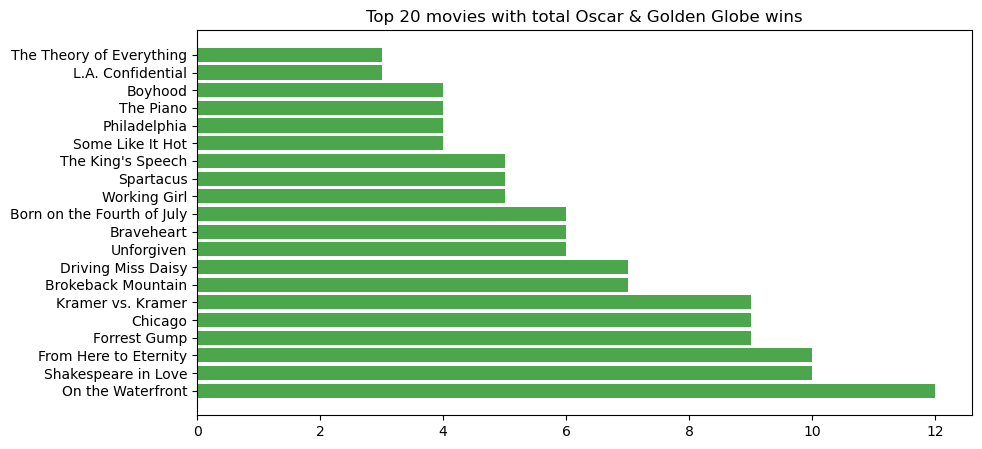

In [91]:
# plt.barh(x, y)
x=top20_movies['Title']
y=top20_movies['Cumulative_Awards']
plt.figure(figsize=(10,5))
plt.title('Top 20 movies with total Oscar & Golden Globe wins')
plt.barh(x,y,color='green',alpha=0.7)

In [92]:
# Take a look at how many awards were won by each decade
per_decade_wins=both_awards['Decades'].value_counts()
per_decade_wins

Decades
1990s    8
2010s    7
1950s    5
1980s    5
2000s    4
1960s    2
1970s    1
1920s    0
1930s    0
1940s    0
2020s    0
Name: count, dtype: int64

<BarContainer object of 11 artists>

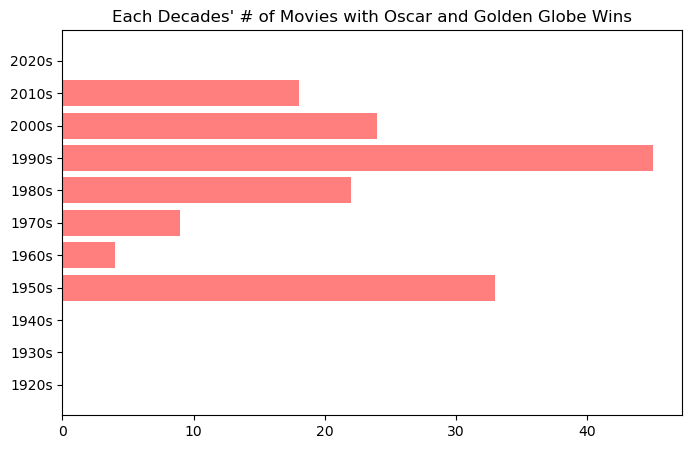

In [93]:
# Bar plot for cumulative Oscar and Golden Globe wins by Decade
decade_groupby = both_awards.groupby('Decades')
decades_sum=decade_groupby['Cumulative_Awards'].sum().reset_index()
decades_sum['Cumulative_Awards']
x=decades_sum['Decades']
y=decades_sum['Cumulative_Awards']
#plt.xlabel("Total oscar and golden globe wins")

plt.figure(figsize=(8,5))
plt.title(f"Each Decades' # of Movies with Oscar and Golden Globe Wins")
plt.barh(x,y,color='red',alpha=0.5)